# Imports, functions and Initial Setup

Importing necessary libraries used for recommendation modeling and data preprocessing.

In [101]:
import pandas as pd
import numpy as np
from surprise import SVDpp, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from itertools import product
import time
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
import os
from scipy.stats import entropy
import seaborn as sns


## Functions

### Functions for initial setup 

The function `load_data` loads the MovieLens dataset from a specified CSV file created in the EDA

In [37]:
def load_data(filepath):
    """
    Load the MovieLens dataset from a CSV file
    
    Parameters:
    -----------
    filepath : str
        Path to the dataset file
    
    Returns:
    --------
    pd.DataFrame
        Loaded dataset
    """
    ratings = pd.read_csv(filepath)
    print(ratings.head())
    print(ratings.shape)
    return ratings

The function `create_user_item_matrix` transforms the ratings DataFrame into a pivoted user-item matrix, where each row represents a user, each column represents a movie, and cell values indicate ratings given by users.

In [38]:
def create_user_item_matrix(ratings_df):
    """
    Create a user-item matrix from the ratings dataframe
    
    Parameters:
    -----------
    ratings_df : pd.DataFrame
        Dataframe containing ratings
    
    Returns:
    --------
    pd.DataFrame
        User-item matrix where rows are users, columns are movies and cells are ratings
    """
    user_item_matrix = ratings_df.pivot_table(
        index='UserID',
        columns='MovieID',
        values='Rating'
    )
    print(user_item_matrix.shape)
    return user_item_matrix

The `split_train_test` function splits a user-item matrix into training and testing sets by distributing each user's ratings, maintaining approximately 80% of ratings in the training set and 20% in the test set. It only includes users with at least 44 ratings (by default) while skipping users who don't meet this threshold, ensuring a clean separation without overlap.

In [39]:
def split_train_test(user_item_matrix, test_size=0.2, random_state=42, min_ratings=44, include_all_users=False):
    """
    Split the data into training and testing sets
    
    Parameters:
    -----------
    user_item_matrix : pd.DataFrame
        User-item matrix
    test_size : float
        Proportion of data to be used for testing
    random_state : int
        Random seed for reproducibility
    min_ratings : int, default=44
        Minimum number of ratings required for a user to be included in train-test split
        (users with fewer ratings will be handled according to include_all_users)
    include_all_users : bool, default=False
        If True, include users with fewer than min_ratings in the training set
        If False, these users will be excluded entirely
    
    Returns:
    --------
    pd.DataFrame, pd.DataFrame
        Training matrix and testing matrix
    """
    
    # Create empty train/test matrices with same shape and NaNs
    train_matrix = user_item_matrix.copy() * np.nan
    test_matrix = user_item_matrix.copy() * np.nan
    
    # Count users according to how they'll be handled
    users_with_test_split = 0
    users_all_in_train = 0
    users_skipped = 0
    
    # Split each user's ratings
    for user_id in user_item_matrix.index:
        user_ratings = user_item_matrix.loc[user_id]
        rated_items = user_ratings.dropna()
        
        # Case 1: User has enough ratings for train-test split
        if len(rated_items) >= min_ratings:
            # Random shuffle
            shuffled = rated_items.sample(frac=1, random_state=random_state)
            
            cutoff = int((1-test_size) * len(shuffled))
            train_items = shuffled.iloc[:cutoff]
            test_items = shuffled.iloc[cutoff:]
            
            # Assign ratings back to correct columns
            train_matrix.loc[user_id, train_items.index] = train_items.values
            test_matrix.loc[user_id, test_items.index] = test_items.values
            
            users_with_test_split += 1
            
        # Case 2: User doesn't have enough ratings for test split but we want to include them
        elif include_all_users and len(rated_items) > 0:
            # Put all ratings in training set
            train_matrix.loc[user_id, rated_items.index] = rated_items.values
            users_all_in_train += 1
            
        # Case 3: Skip user entirely (happens when include_all_users=False)
        else:
            users_skipped += 1
    
    # Print summary of how users were handled
    total_users = len(user_item_matrix.index)
    print(f"=== Train-Test Split Summary ===")
    print(f"Total users in original data: {total_users}")
    print(f"Users with train-test split: {users_with_test_split} ({users_with_test_split/total_users*100:.2f}%)")
    
    if include_all_users:
        print(f"Users with all ratings in train: {users_all_in_train} ({users_all_in_train/total_users*100:.2f}%)")
    else:
        print(f"Users skipped (< {min_ratings} ratings): {users_skipped} ({users_skipped/total_users*100:.2f}%)")
    
    # Check total ratings
    original_count = (~user_item_matrix.isna()).sum().sum()
    train_count = (~train_matrix.isna()).sum().sum()
    test_count = (~test_matrix.isna()).sum().sum()
    total_included = train_count + test_count
    
    print(f"\n=== Rating Distribution ===")
    print(f"Original ratings: {original_count}")
    print(f"Train ratings: {train_count} ({train_count/original_count*100:.2f}%)")
    print(f"Test ratings: {test_count} ({test_count/original_count*100:.2f}%)")
    print(f"Total included: {total_included} ({total_included/original_count*100:.2f}%)")
    
    if original_count != total_included:
        print(f"Missing ratings: {original_count - total_included} ({(original_count - total_included)/original_count*100:.2f}%)")
        print(f"These are from users with fewer than {min_ratings} ratings who were {'partially included in train' if include_all_users else 'skipped'}")
    
    return train_matrix, test_matrix

The `verify_split` function verifies the correctness of a train-test split by checking that all ratings from users with at least 44 ratings are preserved, properly distributed, and have no overlap between sets. It provides detailed analysis of user distribution and rating patterns, validating that users with sufficient ratings are included in both datasets while explicitly accounting for the intentional exclusion of users with fewer ratings.

In [99]:
def verify_split(original_matrix, train_matrix, test_matrix, min_ratings=44, validate_only_included_users=True):
    """
    Verify the correctness of the train-test split
    
    Parameters:
    -----------
    original_matrix : pd.DataFrame
        Original user-item matrix
    train_matrix : pd.DataFrame
        Training matrix
    test_matrix : pd.DataFrame
        Testing matrix
    min_ratings : int, default=44
        Minimum number of ratings used as threshold in the split
    validate_only_included_users : bool, default=True
        If True, validation will only check if users with >= min_ratings are properly included
        If False, expects all users to be included regardless of rating count
    
    Returns:
    --------
    bool
        Whether the split is valid based on the specified criteria
    """
    
    # Total number of ratings check
    original_count = (~original_matrix.isna()).sum().sum()
    train_count = (~train_matrix.isna()).sum().sum()
    test_count = (~test_matrix.isna()).sum().sum()
    total_split_count = train_count + test_count
    
    print(f"Original rating count: {original_count}")
    print(f"Train rating count:    {train_count}")
    print(f"Test rating count:     {test_count}")
    print(f"Total (train + test):  {total_split_count}")
    
    # Rating preservation check
    if validate_only_included_users:
        # Count ratings of users with at least min_ratings
        sufficient_ratings_users = original_matrix.index[
            (~original_matrix.isna()).sum(axis=1) >= min_ratings
        ]
        original_filtered_count = (~original_matrix.loc[sufficient_ratings_users].isna()).sum().sum()
        print(f"Original rating count (users with >= {min_ratings} ratings): {original_filtered_count}")
        print(f"Rating count preserved for included users: {original_filtered_count == total_split_count}")
        ratings_preserved = (original_filtered_count == total_split_count)
    else:
        # Check all ratings
        print(f"Rating count preserved (all users): {original_count == total_split_count}")
        ratings_preserved = (original_count == total_split_count)
    
    # Overlap check
    overlap = (~train_matrix.isna()) & (~test_matrix.isna())
    overlap_count = overlap.sum().sum()
    print(f"Overlapping ratings in train and test: {overlap_count}")  # Should be 0
    print(f"No overlap between train and test: {overlap_count == 0}")
    
    # User distribution check
    print("\n=== User Distribution Analysis ===")
    
    # Get active users in each matrix
    train_active_users = train_matrix.index[train_matrix.notna().any(axis=1)]
    test_active_users = test_matrix.index[test_matrix.notna().any(axis=1)]
    original_active_users = original_matrix.index[original_matrix.notna().any(axis=1)]
    
    # Users by rating count
    user_rating_counts = (~original_matrix.isna()).sum(axis=1)
    users_with_sufficient_ratings = original_matrix.index[user_rating_counts >= min_ratings].tolist()
    users_with_insufficient_ratings = original_matrix.index[user_rating_counts < min_ratings].tolist()
    
    print(f"Total users in original data: {len(original_active_users)}")
    print(f"Users with >= {min_ratings} ratings: {len(users_with_sufficient_ratings)} ({len(users_with_sufficient_ratings)/len(original_active_users)*100:.2f}%)")
    print(f"Users with < {min_ratings} ratings: {len(users_with_insufficient_ratings)} ({len(users_with_insufficient_ratings)/len(original_active_users)*100:.2f}%)")
    print(f"Users in train set: {len(train_active_users)} ({len(train_active_users)/len(original_active_users)*100:.2f}%)")
    print(f"Users in test set: {len(test_active_users)} ({len(test_active_users)/len(original_active_users)*100:.2f}%)")
    
    # Users in both train and test
    users_in_both = set(train_active_users).intersection(set(test_active_users))
    print(f"Users in both train and test: {len(users_in_both)} ({len(users_in_both)/len(original_active_users)*100:.2f}%)")
    
    # Users only in train or test
    users_only_in_train = set(train_active_users) - set(test_active_users)
    users_only_in_test = set(test_active_users) - set(train_active_users)
    print(f"Users only in train: {len(users_only_in_train)} ({len(users_only_in_train)/len(original_active_users)*100:.2f}%)")
    print(f"Users only in test: {len(users_only_in_test)} ({len(users_only_in_test)/len(original_active_users)*100:.2f}%)")
    
    # Check for missing users
    missing_users = set(original_active_users) - set(train_active_users).union(set(test_active_users))
    missing_users_with_sufficient_ratings = set(users_with_sufficient_ratings) - set(train_active_users).union(set(test_active_users))
    
    if validate_only_included_users:
        if len(missing_users_with_sufficient_ratings) > 0:
            print(f"WARNING: {len(missing_users_with_sufficient_ratings)} users with >= {min_ratings} ratings are missing from both train and test!")
        else:
            print(f"All users with >= {min_ratings} ratings are included in the split")
        
        print(f"Users with < {min_ratings} ratings excluded from split: {len(missing_users)}")
    else:
        if len(missing_users) > 0:
            print(f"WARNING: {len(missing_users)} users from original data are missing in both train and test!")
    
    # Analyze per-user rating distribution for included users
    print("\n=== Per-User Rating Distribution ===")
    
    user_stats = {}
    for user in set(train_active_users).union(set(test_active_users)):
        train_ratings = (~train_matrix.loc[user].isna()).sum() if user in train_matrix.index else 0
        test_ratings = (~test_matrix.loc[user].isna()).sum() if user in test_matrix.index else 0
        total_ratings = train_ratings + test_ratings
        
        if total_ratings > 0:
            user_stats[user] = {
                'train_count': train_ratings,
                'test_count': test_ratings,
                'total_count': total_ratings,
                'train_ratio': train_ratings / total_ratings,
                'test_ratio': test_ratings / total_ratings
            }
    
    # Calculate average split proportions
    if user_stats:
        avg_train_ratio = sum(stats['train_ratio'] for stats in user_stats.values()) / len(user_stats)
        avg_test_ratio = sum(stats['test_ratio'] for stats in user_stats.values()) / len(user_stats)
        print(f"Average per-user train ratio: {avg_train_ratio:.2f} ({avg_train_ratio*100:.2f}%)")
        print(f"Average per-user test ratio: {avg_test_ratio:.2f} ({avg_test_ratio*100:.2f}%)")
        
        # Distribution of train-test split ratios
        train_ratios = [stats['train_ratio'] for stats in user_stats.values()]
        ratio_bins = np.linspace(0, 1, 11)  # 0%, 10%, 20%, ..., 100%
        hist, _ = np.histogram(train_ratios, bins=ratio_bins)
        
        print("\nDistribution of train ratios across users:")
        for i in range(len(hist)):
            print(f"{ratio_bins[i]*100:3.0f}%-{ratio_bins[i+1]*100:3.0f}%: {hist[i]} users")
    
    # Final validation
    if validate_only_included_users:
        valid_user_inclusion = (len(missing_users_with_sufficient_ratings) == 0)
        print("\n=== Final Validation ===")
        print(f" Rating count preserved for included users: {ratings_preserved}")
        print(f" No overlap between train and test: {overlap_count == 0}")
        print(f" All users with >= {min_ratings} ratings included: {valid_user_inclusion}")
        
        return ratings_preserved and (overlap_count == 0) and valid_user_inclusion
    else:
        valid_all_users_included = (len(missing_users) == 0)
        print("\n=== Final Validation ===")
        print(f" Rating count preserved (all users): {ratings_preserved}")
        print(f" No overlap between train and test: {overlap_count == 0}")
        print(f" All users included in either train or test: {valid_all_users_included}")
        
        return ratings_preserved and (overlap_count == 0) and valid_all_users_included

The `convert_to_long_format` transforms a user-item ratings matrix into a long-format dataframe because SVD++ needs a long format dataset

In [41]:
def convert_to_long_format(matrix):
    """
    Convert a matrix to long format (user, item, rating)
    
    Parameters:
    -----------
    matrix : pd.DataFrame
        User-item matrix
    
    Returns:
    --------
    pd.DataFrame
        Long format dataframe with columns UserID, MovieID, Rating
    """
    long_df = matrix.stack().reset_index()
    long_df.columns = ['UserID', 'MovieID', 'Rating']
    return long_df

### Functions for SVD++ modelling

The `prepare_svdpp_pipeline` function handles the complete data preparation process for SVD++ modeling in the Surprise library.

In [42]:
def prepare_svdpp_pipeline(train_long_df, test_long_df, create_validation=False, 
                          validation_size=0.2, random_state=42):
    """
    Complete pipeline to prepare data for SVD++ model training
    
    Parameters:
    -----------
    train_long_df : pd.DataFrame
        Training data in long format
    test_long_df : pd.DataFrame
        Testing data in long format
    create_validation : bool, default=False
        Whether to create a validation set from training data
    validation_size : float, default=0.2
        Proportion of training data to use for validation
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    tuple
        If create_validation=False: (full_trainset, custom_testset)
        If create_validation=True: (smaller_trainset, validation_set, custom_testset)
    """
    # Step 1: Create a reader and load train data
    reader = Reader(rating_scale=(1, 5))
    train_data_dataset = Dataset.load_from_df(train_long_df[['UserID', 'MovieID', 'Rating']], reader)
    
    # Step 2: Build the full trainset
    full_trainset = train_data_dataset.build_full_trainset()
    
    # Step 3: Prepare testset in Surprise format: [(uid, iid, true_rating)]
    custom_testset = list(test_long_df.itertuples(index=False, name=None))
    
    # Step 4: Create validation split if requested
    if create_validation:
        # Re-wrap full trainset into DataFrame
        train_df_for_tuning = pd.DataFrame(full_trainset.build_testset(), 
                                         columns=['UserID', 'MovieID', 'Rating'])
        
        # Load it into a new dataset and split it for tuning
        tuning_data = Dataset.load_from_df(train_df_for_tuning, reader)
        smaller_trainset, validation_set = train_test_split(tuning_data, 
                                                          test_size=validation_size, 
                                                          random_state=random_state)
        
        return smaller_trainset, validation_set, custom_testset
    
    return full_trainset, custom_testset

`grid_search_svdpp`: Performs a grid search over SVD++ parameters

- Takes trainset, validation set, and parameter grid as inputs
- Returns the best parameters, best RMSE, and a dictionary of all results
- Includes progress tracking and timing information
- Has a verbose option to control output detail

In [43]:
def grid_search_svdpp(trainset, validation_set, param_grid, random_state=42, verbose=True):
    """
    Perform grid search over SVD++ parameters
    
    Parameters:
    -----------
    trainset : surprise.Trainset
        Training dataset
    validation_set : list
        Validation set in Surprise format (list of tuples)
    param_grid : dict
        Dictionary with parameter names as keys and lists of parameter values to try
    random_state : int, default=42
        Random seed for reproducibility
    verbose : bool, default=True
        Whether to print progress information
    
    Returns:
    --------
    dict, float, dict
        Best parameters, best RMSE, and full results dictionary mapping parameters to RMSE values
    """
    best_rmse = float('inf')
    best_params = None
    all_results = {}
    
    # Get total combinations for progress logging
    keys, values = zip(*param_grid.items())
    total_combinations = len(list(product(*values)))
    combo_count = 1
    
    if verbose:
        print(f"Starting grid search over {total_combinations} combinations...\n")
    
    for combo in product(*values):
        params = dict(zip(keys, combo))
        
        if verbose:
            print(f"[{combo_count}/{total_combinations}] Training with params: {params}")
        
        start_time = time.time()
        
        # Train model
        model = SVDpp(**params, random_state=random_state, verbose=False)
        model.fit(trainset)
        
        # Predict on validation set
        predictions = model.test(validation_set)
        rmse = accuracy.rmse(predictions, verbose=False)
        
        # Store result
        param_tuple = tuple(params.items())
        all_results[param_tuple] = rmse
        
        elapsed = time.time() - start_time
        
        if verbose:
            print(f"Completed in {elapsed:.2f} seconds — RMSE: {rmse:.4f}")
            
        if rmse < best_rmse:
            if verbose:
                print(f"New best RMSE, (was {best_rmse:.4f})")
            best_rmse = rmse
            best_params = params
        
        if verbose:
            print("-" * 50)
            
        combo_count += 1
    
    if verbose:
        print(f"\nGrid search complete. Best RMSE: {best_rmse:.4f}")
        print(f"Best parameters: {best_params}")
    
    # Convert results to a more usable form (dictionary of dictionaries)
    formatted_results = {}
    for param_tuple, rmse in all_results.items():
        param_dict = dict(param_tuple)
        param_key = str(param_dict)  # Use string representation as key
        formatted_results[param_key] = {
            'params': param_dict,
            'rmse': rmse
        }
    
    return best_params, best_rmse, formatted_results

`train_best_svdpp`: Trains the final model with the best parameters

- Takes full training data, test data, and best parameters
- Returns the trained model and test RMSE
- Also includes timing information and verbose control

In [44]:
def train_best_svdpp(train_data, test_data, best_params, random_state=42, verbose=True):
    """
    Train the SVD++ model with the best parameters on the full training set
    and evaluate on the test set
    
    Parameters:
    -----------
    train_data : surprise.Trainset
        Full training dataset
    test_data : list
        Test set in Surprise format (list of tuples)
    best_params : dict
        Best parameters found during grid search
    random_state : int, default=42
        Random seed for reproducibility
    verbose : bool, default=True
        Whether to print progress information
    
    Returns:
    --------
    surprise.prediction_algorithms.matrix_factorization.SVDpp, float
        Trained model and test RMSE
    """
    if verbose:
        print(f"Training final model with best parameters: {best_params}")
    
    start_time = time.time()
    
    # Train model on full training data
    final_model = SVDpp(**best_params, random_state=random_state, verbose=False)
    final_model.fit(train_data)
    
    # Evaluate on test set
    test_predictions = final_model.test(test_data)
    test_rmse = accuracy.rmse(test_predictions, verbose=False)
    
    elapsed = time.time() - start_time
    
    if verbose:
        print(f"Final model training completed in {elapsed:.2f} seconds")
        print(f"Test RMSE: {test_rmse:.4f}")
    
    return final_model, test_rmse

### Functions for model evaluations

The `evaluate_model_fairness` function assesses how equitably the recommendation model performs across different demographic groups.

**Function process** 
- Generate Predictions: Uses the trained model to make predictions on the test set.
- Calculate Overall Performance: Computes the baseline RMSE across all test data.
- Merge Demographics: Combines prediction results with user demographic information (gender, age groups).
- Segment-Specific Analysis: For each demographic dimension:
    - Identifies all unique demographic values (e.g., 'M', 'F' for gender).
    - Calculates group-specific RMSE for each demographic value.
    - Determines the maximum RMSE difference between any two groups.

- Fairness Metrics Calculation: Quantifies potential disparities in recommendation quality:
    - Max difference in RMSE between demographic groups.
    - Separate performance metrics for each demographic segment.

In [45]:
def evaluate_model_fairness(model, testset, ratings_df, demographic_cols=['Gender', 'AgeDesc']):
    """
    Evaluate model fairness across demographic groups
    
    Parameters:
    -----------
    model : surprise.prediction_algorithms
        Trained recommendation model
    testset : list
        Test set in Surprise format (list of tuples)
    ratings_df : pd.DataFrame
        Original ratings dataframe with demographic information
    demographic_cols : list, default=['Gender', 'AgeDesc']
        Columns to use for demographic analysis
    
    Returns:
    --------
    pd.DataFrame, dict
        DataFrame with predictions and demographics, and dictionary with fairness metrics
    """
    # Generate predictions
    predictions = model.test(testset)
    
    # Overall RMSE
    overall_rmse = accuracy.rmse(predictions)
    print(f"Overall Test RMSE: {overall_rmse:.4f}")
    
    # Convert predictions to DataFrame
    pred_df = pd.DataFrame([(p.uid, p.iid, p.r_ui, p.est) for p in predictions], 
                         columns=['UserID', 'MovieID', 'r_ui', 'est'])
    
    # Extract unique user demographics
    user_demographics = ratings_df[['UserID'] + demographic_cols].drop_duplicates()
    
    # Merge predictions with demographics
    results_with_demographics = pred_df.merge(user_demographics, on='UserID')
    
    # Initialize results dictionary
    fairness_metrics = {'overall_rmse': overall_rmse}
    
    # Analyze each demographic dimension
    for col in demographic_cols:
        print(f"\n=== Fairness Analysis by {col} ===")
        
        # Get unique values for this demographic
        unique_values = ratings_df[col].unique()
        
        # Calculate RMSE for each group
        group_rmse = {}
        for value in unique_values:
            group_preds = results_with_demographics[results_with_demographics[col] == value]
            if len(group_preds) > 0:
                group_rmse[value] = np.sqrt(np.mean((group_preds['r_ui'] - group_preds['est']) ** 2))
                print(f"RMSE for {col}={value}: {group_rmse[value]:.4f} (n={len(group_preds)})")
        
        # Calculate fairness metrics (max difference between groups)
        if len(group_rmse) > 1:
            rmse_values = list(group_rmse.values())
            max_diff = max(rmse_values) - min(rmse_values)
            print(f"Max {col} RMSE difference: {max_diff:.4f}")
            
            # Store in results
            fairness_metrics[f'{col}_rmse'] = group_rmse
            fairness_metrics[f'{col}_max_diff'] = max_diff
    
    return results_with_demographics, fairness_metrics

The `analyze_prediction_bias` function examines systematic errors in the model's predictions across different user groups and rating values:

**Function process**
- Error Calculation: Computes the prediction error (predicted rating - actual rating) for each test case.
    - Positive values indicate overestimation.
    - Negative values indicate underestimation.


- Overall Bias Assessment: Calculates the mean error across all predictions to detect general tendencies to over/under-predict.

- Rating-Specific Analysis:
    - Groups actual ratings into bins (e.g., 1-2, 2-3, 3-4, 4-5).
    - Analyzes if bias differs based on rating value.
    - Identifies if the model is more accurate for certain rating ranges.

- Demographic Bias Analysis: For each demographic dimension:
    - Computes the average error for each demographic group.
    - Determines if certain groups consistently receive over or under-predictions.

- Intersectional Analysis: Examines bias at intersections of demographics and rating values.
    - Checks if high ratings from certain groups are treated differently than low ratings.

In [46]:
def analyze_prediction_bias(results_with_demographics, rating_bins=None):
    """
    Analyze prediction bias across rating values and demographics
    
    Parameters:
    -----------
    results_with_demographics : pd.DataFrame
        DataFrame with predictions and demographic information
    rating_bins : list, default=None
        Rating bins for analysis (default: [0, 1, 2, 3, 4, 5])
        
    Returns:
    --------
    dict
        Dictionary with bias analysis results
    """
    if rating_bins is None:
        rating_bins = [0, 1, 2, 3, 4, 5]
    
    # Calculate prediction error
    results_with_demographics['error'] = results_with_demographics['est'] - results_with_demographics['r_ui']
    
    print("\n=== Prediction Bias Analysis ===")
    
    # Overall bias
    mean_error = results_with_demographics['error'].mean()
    print(f"Overall mean error (bias): {mean_error:.4f}")
    
    # Bin actual ratings
    results_with_demographics['rating_bin'] = pd.cut(
        results_with_demographics['r_ui'], 
        bins=rating_bins,
        labels=[f"{rating_bins[i]}-{rating_bins[i+1]}" for i in range(len(rating_bins)-1)]
    )
    
    # Analyze bias by rating bin
    bias_by_rating = results_with_demographics.groupby('rating_bin')['error'].agg(['mean', 'count'])
    print("\nBias by rating value:")
    print(bias_by_rating)
    
    # Analyze bias by demographics
    demographic_cols = [col for col in results_with_demographics.columns 
                      if col not in ['UserID', 'MovieID', 'r_ui', 'est', 'error', 'rating_bin']]
    
    bias_results = {
        'overall_bias': mean_error,
        'bias_by_rating': bias_by_rating.to_dict()
    }
    
    for col in demographic_cols:
        bias_by_group = results_with_demographics.groupby(col)['error'].agg(['mean', 'count'])
        print(f"\nBias by {col}:")
        print(bias_by_group)
        
        bias_results[f'bias_by_{col}'] = bias_by_group.to_dict()
        
        # Bias by demographic and rating
        bias_by_group_rating = results_with_demographics.groupby([col, 'rating_bin'])['error'].agg(['mean', 'count'])
        bias_results[f'bias_by_{col}_rating'] = bias_by_group_rating.to_dict()
    
    return bias_results

The `visualize_fairness_results` function creates intuitive visual representations of the fairness analysis:

**Function process**

- Error Distribution Visualization:
    - Creates boxplots showing the distribution of prediction errors for each demographic group.
    - Allows for quick visual identification of differences in error patterns across groups.
    - Reveals not just average error but also error variance and outliers by group.

- Actual vs. Predicted Visualization:
    - Generates scatter plots of actual ratings against predicted ratings.
    - Segments data points by demographic group using different colors.
    - Includes a reference line showing perfect predictions (where actual = predicted).
    - Helps identify if certain groups consistently fall above or below the ideal prediction line.

- Multi-panel Dashboard Layout:
    - Organizes visualizations in a grid layout for easy comparison.
    - Creates separate panels for each demographic dimension (Gender, Age groups).
    - Allows for simultaneous comparison across different fairness dimensions.

In [100]:
def visualize_fairness_results(results_with_demographics, fairness_metrics):
    """
    Create visualizations for fairness analysis
    
    Parameters:
    -----------
    results_with_demographics : pd.DataFrame
        DataFrame with predictions and demographic information
    fairness_metrics : dict
        Dictionary with fairness metrics
        
    Returns:
    --------
    None
        Displays visualizations
    """
    try:
        
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Error distribution by demographic groups
        demographic_cols = [col for col in results_with_demographics.columns 
                          if col in ['Gender', 'AgeDesc']]
        
        for i, col in enumerate(demographic_cols):
            plt.subplot(2, len(demographic_cols), i+1)
            sns.boxplot(x=col, y='error', data=results_with_demographics)
            plt.title(f'Error Distribution by {col}')
            plt.tight_layout()
        
        # Plot 2: Actual vs Predicted by demographic
        for i, col in enumerate(demographic_cols):
            plt.subplot(2, len(demographic_cols), len(demographic_cols) + i+1)
            
            groups = results_with_demographics[col].unique()
            for group in groups:
                group_data = results_with_demographics[results_with_demographics[col] == group]
                plt.scatter(group_data['r_ui'], group_data['est'], alpha=0.3, label=group)
            
            plt.plot([1, 5], [1, 5], 'k--')  # Perfect prediction line
            plt.xlabel('Actual Rating')
            plt.ylabel('Predicted Rating') 
            plt.legend()
            plt.title(f'Actual vs Predicted by {col}')
            plt.tight_layout()
        
        plt.show()
        
    except ImportError:
        print("Matplotlib and/or Seaborn not available. Skipping visualizations.")

### Functions for fairness metrics (individual fairness)

#### Gini coefficient

The `gini_coefficient` function calculates a standard inequality metric based on the distribution of values.

**Function process**

- Data Preparation:
    - Converts input values to a numpy array for efficient processing.
    - Sorts values in ascending order to calculate cumulative distribution.
    - Handles edge cases where the array is empty or contains only zeros.

- Cumulative Distribution:
    - Computes the cumulative sum of sorted values.
    - Determines the total sum for normalization purposes.

- Coefficient Calculation:
    - Applies the mathematical formula for Gini coefficient using weighted positions.
    - Weights each value by its relative position in the sorted array.
    - Normalizes by the number of elements and their total sum.

- Result Interpretation:
    - Returns a value between 0 and 1.
    - Value of 0 indicates perfect equality (all values are identical).
    - Value of 1 represents perfect inequality (one element has everything).
    - Higher values indicate greater inequality in the distribution.

In [48]:
def gini_coefficient(values):
    """
    Calculate the Gini coefficient to measure inequality in a distribution.
    
    Parameters:
    -----------
    values : list or numpy.array
        Values representing the distribution to measure inequality
    
    Returns:
    --------
    float
        Gini coefficient (0 = perfect equality, 1 = perfect inequality)
    """
    # Convert to numpy array and sort
    values = np.array(values)
    sorted_values = np.sort(values)
    n = len(values)
    
    # Handle edge case
    if n == 0 or np.sum(values) == 0:
        return 0
    
    # Calculate cumulative values
    cumulative_values = np.cumsum(sorted_values)
    total_value = cumulative_values[-1]
    
    # Calculate Gini coefficient
    numerator = np.sum((2 * np.arange(1, n+1) - n - 1) * sorted_values)
    denominator = n * total_value
    
    return numerator / denominator if denominator != 0 else 0

The `get_top_n_recommendations` function extracts the highest-rated items for each user from a model's predictions.

**Function process**

- Prediction Collection:
    - Creates a default dictionary to store recommendations by user ID.
    - Iterates through all prediction objects generated by the Surprise model.
    - Captures each prediction's item ID, estimated rating, and true rating.

- Recommendation Organization:
    - Groups all predicted ratings by user ID, maintaining the complete set of predictions per user.
    - Preserves both the model's estimated ratings and the actual ground truth ratings.

- Selection and Ranking:
    - Sorts each user's predictions by estimated rating in descending order.
    - Retains only the top N items with highest predicted ratings for each user.
    - Ensures consistent recommendation count across users for fair comparison.

- Result Structure:
    - Returns a dictionary where keys are user IDs.
    - Each value contains a list of tuples (item_id, estimated_rating, true_rating).
    - Maintains both predicted and actual ratings to enable precision calculation.

In [49]:
def get_top_n_recommendations(predictions, n=10):
    """
    Return top-N recommendations for each user from Surprise predictions.
    
    Parameters:
    -----------
    predictions : list
        Prediction objects from Surprise's algorithm.test() method
    n : int, default=10
        Number of top recommendations to keep for each user
    
    Returns:
    --------
    dict
        Dictionary mapping user IDs to their top N recommendations,
        where each recommendation is (item_id, estimated_rating, true_rating)
    """
    top_n = defaultdict(list)
    
    # Collect all predictions for each user
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))
    
    # Sort by estimated rating and keep top n
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

The `calculate_user_precision` function measures the accuracy of recommendations at the individual user level.

**Function process**

- Precision Initialization:
    - Creates an empty dictionary to store precision values for each user.
    - Processes each user's recommended items independently.
    - Skips users with no recommendations to avoid division by zero.

- Relevance Determination:
    - Examines the true rating for each recommended item.
    - Applies a threshold (default 4.0) to classify items as relevant or not relevant.
    - Counts how many recommended items meet or exceed this relevance threshold.

- Precision Calculation:
    - Computes the ratio of relevant items to total recommended items for each user.
    - Precision of 1.0 means all recommended items were truly relevant.
    - Precision of 0.0 means none of the recommended items were relevant.

- Result Collection:
    - Maps each user ID to their calculated precision score.
    - Returns a complete dictionary of user-level precision values.
    - These individualized metrics form the basis for fairness analysis.

In [50]:
def calculate_user_precision(top_n, threshold=4.0):
    """
    Calculate precision for each user: proportion of recommended items with true rating >= threshold.
    
    Parameters:
    -----------
    top_n : dict
        Dictionary of top N recommendations per user from get_top_n_recommendations()
    threshold : float, default=4.0
        Rating threshold to consider an item relevant
        
    Returns:
    --------
    dict
        Dictionary mapping user IDs to their precision values
    """
    user_precisions = {}
    
    for uid, user_recs in top_n.items():
        n = len(user_recs)
        if n == 0:
            continue
            
        # Count relevant items (true rating >= threshold)
        relevant = sum(1 for _, _, true_r in user_recs if true_r >= threshold)
        precision = relevant / n
        
        user_precisions[uid] = precision
    
    return user_precisions

The `plot_lorenz_curve function` creates a visual representation of distribution inequality.

**Function process**

- Data Preparation:
    - Converts input values to array format and sorts them ascending.
    - Calculates cumulative sums and normalizes to percentages.
    - Creates percentile points for the x-axis.

- Curve Rendering:
    - Plots the Lorenz curve showing cumulative value distribution.
    - Adds a reference diagonal line representing perfect equality.
    - Highlights the area between curves to visualize inequality magnitude.

- Visualization Enhancement:
    - Optionally calculates and displays the Gini coefficient.
    - Adds informative labels, legend, and grid for clarity.
    - Customizes figure size and formatting for better readability.

In [51]:
def plot_lorenz_curve(values, title="Lorenz Curve", show_gini=True, figsize=(8, 6)):
    """
    Plot Lorenz curve from values and optionally display Gini coefficient.
    
    Parameters:
    -----------
    values : list or numpy.array
        Values representing the distribution to analyze
    title : str, default="Lorenz Curve"
        Title for the plot
    show_gini : bool, default=True
        Whether to calculate and display Gini coefficient in the plot
    figsize : tuple, default=(8, 6)
        Figure size (width, height) in inches
    """
    values = np.array(values)
    
    # Sort values and calculate cumulative distribution
    values_sorted = np.sort(values)
    cumvals = np.cumsum(values_sorted)
    
    # Normalize to get cumulative percentage
    if cumvals[-1] > 0:
        cumvals_normalized = cumvals / cumvals[-1]
    else:
        cumvals_normalized = np.zeros_like(cumvals)
    
    # Create percentile points for x-axis
    cumpercent_items = np.linspace(0, 1, len(values) + 1)
    
    # Calculate Gini coefficient if requested
    gini = None
    if show_gini:
        gini = gini_coefficient(values)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Plot Lorenz curve
    plt.plot(cumpercent_items, np.insert(cumvals_normalized, 0, 0), 
            label="Lorenz Curve", color="blue", linewidth=2)
    
    # Plot line of equality
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Line of Equality")
    
    # Fill area between curves
    plt.fill_between(cumpercent_items, np.insert(cumvals_normalized, 0, 0), 
                   np.linspace(0, 1, len(values)+1), 
                   color="red", alpha=0.2, label="Inequality Area")
    
    # Add labels and title
    plt.xlabel("Cumulative % of Users")
    plt.ylabel("Cumulative % of Total Value")
    
    if show_gini and gini is not None:
        plt.title(f"{title}\nGini Coefficient: {gini:.4f}")
    else:
        plt.title(title)
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

The `evaluate_gini_fairness` function measures inequality in recommendation quality across users.

**Function process**

- Recommendation Generation:
    - Uses the trained model to generate predictions on the test dataset.
    - Identifies the top-N recommendations for each user based on predicted ratings.

- Precision Calculation:
    - Computes precision for each individual user (proportion of relevant recommendations).
    - Defines relevance based on whether actual ratings exceed a specified threshold.

- Gini Coefficient Calculation:
    - Measures the inequality in precision distribution across all users.
    - Produces a value between 0 (perfect equality) and 1 (perfect inequality).

- Lorenz Curve Visualization:
    - Creates a graphical representation of distribution inequality.
    - Plots cumulative precision against cumulative user percentiles.
    - Includes a reference "line of equality" for comparison.
    - Highlights the area representing inequality between actual and equal distributions.

In [52]:
def evaluate_gini_fairness(model, testset, threshold=4.0, n=10, plot=True):
    """
    Evaluate recommendation fairness using the Gini coefficient.
    
    Parameters:
    -----------
    model : surprise.prediction_algorithms
        Trained recommendation model
    testset : list
        Test set in Surprise format
    threshold : float, default=4.0
        Rating threshold to consider an item relevant
    n : int, default=10
        Number of top recommendations to analyze per user
    plot : bool, default=True
        Whether to generate Lorenz curve plot
        
    Returns:
    --------
    float, dict
        Gini coefficient and dictionary of user precisions
    """
    # Generate predictions
    predictions = model.test(testset)
    
    # Get top-N recommendations for each user
    top_n = get_top_n_recommendations(predictions, n=n)
    
    # Calculate precision for each user
    user_precisions = calculate_user_precision(top_n, threshold=threshold)
    
    # Calculate Gini coefficient
    precision_values = list(user_precisions.values())
    gini = gini_coefficient(precision_values)
    
    print(f"=== Gini Coefficient Fairness Metric ===")
    print(f"Gini Coefficient: {gini:.4f} (0 = perfect equality, 1 = perfect inequality)")
    print(f"Calculated across {len(user_precisions)} users with top-{n} recommendations")
    print(f"Relevance threshold: Rating >= {threshold}")
    
    # Create plot if requested
    if plot:
        plot_lorenz_curve(precision_values, 
                         title="Lorenz Curve of Recommendation Precision", 
                         show_gini=True)
    
    return gini, user_precisions

#### Bottom N-average

The `calculate_bottom_n_average` function identifies and analyzes the worst cases in a distribution.

**Function process**

- Data Preparation:
    - Handles different input formats (DataFrame, Series, or array) for flexibility.
    - Extracts values from the specified column if working with a DataFrame.
    - Ensures the requested sample size doesn't exceed available data.

- Worst-Case Identification:
    - Sorts all values in ascending order to identify the lowest values.
    - Selects the N lowest values from the distribution.
    - These represent the worst experiences or outcomes in the dataset.

- Metric Calculation:
    - Computes the arithmetic mean of the N lowest values.
    - This average represents the experience of the worst-served entities.
    - Returns both the calculated average and the specific values used.

- Edge Case Handling:
    - Manages empty datasets and invalid inputs gracefully.
    - Adjusts sample size automatically if requesting more values than available.

In [53]:
def calculate_bottom_n_average(data, n=10, column=None):
    """
    Calculate the average of the bottom N values in a dataset.
    
    Parameters:
    -----------
    data : array-like, Series, or DataFrame
        The dataset to analyze
    n : int, default 10
        Number of bottom values to include in the average
    column : str, optional
        If data is a DataFrame, the column to use for calculation
        
    Returns:
    --------
    float
        The average of the bottom N values
    list
        The bottom N values used in the calculation
    """
    # Handle different input types
    if isinstance(data, pd.DataFrame):
        if column is None:
            raise ValueError("Column name must be specified when input is a DataFrame")
        values = data[column].values
    elif isinstance(data, pd.Series):
        values = data.values
    else:
        values = np.array(data)
    
    # Make sure n is not larger than the dataset
    n = min(n, len(values))
    
    # Sort the values and get the bottom n
    sorted_values = np.sort(values)
    bottom_n = sorted_values[:n]
    
    # Calculate the average
    bottom_n_avg = np.mean(bottom_n)
    
    return bottom_n_avg, bottom_n.tolist()

The `calculate_user_average_ratings` function summarizes prediction quality at the individual user level.

**Function process**

- User Identification:
    - Uses the specified column to identify unique users in the dataset.
    - Creates a grouping of all predictions belonging to each user.

- Value Aggregation:
    - Collects all prediction values associated with each user.
    - Focuses on the specified value column (typically predicted ratings).

- Average Calculation:
    - Computes the arithmetic mean of all prediction values for each user.
    - This average represents the typical prediction quality experienced by each individual.

- Result Structuring:
    - Returns a pandas Series indexed by user identifiers.
    - Each value represents one user's average prediction quality.
    - Maintains the user-level granularity essential for individual fairness analysis.

In [54]:
def calculate_user_average_ratings(predictions, user_column='UserID', value_column='est'):
    """
    Calculate the average predicted rating for each user.
    
    Parameters:
    -----------
    predictions : pd.DataFrame
        DataFrame containing predictions
    user_column : str, default='UserID'
        Column containing user identifiers
    value_column : str, default='est'
        Column containing the predicted values
        
    Returns:
    --------
    pd.Series
        Series containing average value for each user
    """
    return predictions.groupby(user_column)[value_column].mean()

The `plot_bottom_n_comparison` function visualizes the contrast between average and worst-case experiences.

**Function process**

- Multiple Threshold Analysis:
    - Calculates bottom-N averages for several different sample sizes.
    - Uses the same dataset with multiple N values for consistent comparison.
    - Creates a progression showing how average changes as more users are included.

- Baseline Establishment:
    - Computes the overall average across all data points.
    - Includes this as a reference point to highlight disparities.
    - Creates a visual anchor for understanding the magnitude of differences.

- Visual Representation:
    - Generates a bar chart comparing different bottom-N averages.
    - Assigns distinct colors to each bar for clear differentiation.
    - Adds precise numerical labels to each bar for accurate interpretation.

- Formatting Enhancement:
    - Adds appropriate titles, labels, and grid lines for readability.
    - Maintains consistent sizing and layout for professional presentation.
    - Returns the figure object for potential further customization.

In [55]:
def plot_bottom_n_comparison(data, ns=[5, 10, 20, 50], column=None, title="Bottom N Average Comparison"):
    """
    Plot a comparison of different bottom N averages.
    
    Parameters:
    -----------
    data : array-like, Series, or DataFrame
        The dataset to analyze
    ns : list of int, default [5, 10, 20, 50]
        List of N values to compare
    column : str, optional
        If data is a DataFrame, the column to use for calculation
    title : str, default "Bottom N Average Comparison"
        Title for the plot
    """
    averages = []
    labels = []
    
    # Calculate averages for different values of n
    for n in ns:
        avg, _ = calculate_bottom_n_average(data, n, column)
        averages.append(avg)
        labels.append(f"Bottom {n}")
    
    # Add overall average for comparison
    if isinstance(data, pd.DataFrame) and column is not None:
        overall_avg = data[column].mean()
    elif isinstance(data, pd.Series):
        overall_avg = data.mean()
    else:
        overall_avg = np.mean(data)
    
    averages.append(overall_avg)
    labels.append("Overall")
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, averages, color=['#ff9999', '#66b3ff', '#99ff99', '#c2c2f0', '#ffcc99'])
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')
    
    plt.title(title)
    plt.ylabel("Average Value")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt.gcf()

The `plot_user_rating_distribution` function visualizes how prediction quality varies across the user population.

**Function process**

- Distribution Visualization:
    - Creates a histogram showing how many users experience each rating level.
    - Divides the rating range into specified number of bins for appropriate granularity.
    - Reveals the overall shape and spread of user experiences.

- Reference Markers:
    - Adds a vertical line indicating the overall average rating across all users.
    - Includes a second vertical line showing the average for the bottom 10% of users.
    - Provides visual comparison between typical and worst-case experiences.

- Disparity Highlight:
    - The gap between the two vertical lines illustrates the degree of disparity.
    - Makes the fairness metric visually apparent through spatial separation.
    - Quantifies the difference with precise numerical labels.

- Visual Enhancement:
    - Uses contrasting colors to distinguish between the histogram and reference lines.
    - Adds appropriate titles, labels, and grid for clarity.
    - Includes a legend explaining each element of the visualization.

In [56]:
def plot_user_rating_distribution(user_avg_ratings, bins=20):
    """
    Plot the distribution of average ratings across users.
    
    Parameters:
    -----------
    user_avg_ratings : pd.Series
        Series containing average rating for each user
    bins : int, default=20
        Number of bins for the histogram
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    plt.figure(figsize=(10, 6))
    
    # Plot histogram of user average ratings
    plt.hist(user_avg_ratings, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Add lines for overall average and bottom-N averages
    overall_avg = user_avg_ratings.mean()
    plt.axvline(overall_avg, color='red', linestyle='--', linewidth=2, label=f'Overall Average: {overall_avg:.2f}')
    
    # Add bottom-10% average
    bottom_10_percent = len(user_avg_ratings) // 10
    bottom_n_avg, _ = calculate_bottom_n_average(user_avg_ratings, bottom_10_percent)
    plt.axvline(bottom_n_avg, color='green', linestyle='--', linewidth=2, 
                label=f'Bottom 10% Average: {bottom_n_avg:.2f}')
    
    plt.title('Distribution of Average Ratings Across Users')
    plt.xlabel('Average Rating')
    plt.ylabel('Number of Users')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

The `evaluate_bottom_n_fairness` function measures recommendation quality disparities at the individual user level.

**Function process**

- User-Level Aggregation:
    - Calculates the average prediction quality for each individual user.
    - Establishes the unit of analysis as individual users rather than individual predictions.

- Multiple Threshold Evaluation:
    - Analyzes both fixed-count thresholds (bottom 5, 10, 20 users) and percentage-based thresholds (bottom 1%, 5%, 10%, 20%).
    - Adapts automatically to different dataset sizes by calculating appropriate sample counts.
    - Identifies the average experience of the worst-served users at multiple levels of granularity.

- Disparity Quantification:
    - Calculates the absolute difference between the overall average and each bottom-N average.
    - Computes percentage disparities to provide context for the magnitude of differences.
    - Creates multiple fairness metrics focusing on different subsets of disadvantaged users.

- Comprehensive Visualization:
    - Generates bar charts comparing different bottom-N averages to the overall average.
    - Creates histograms showing the full distribution of user experiences.
    - Highlights critical reference points to visualize the fairness gaps.

- Result Compilation:
    - Collects all metrics and visualizations into a structured results dictionary.
    - Provides detailed output for interpretation and further analysis.
    - Retains raw user averages for potential additional investigation.

In [57]:
def evaluate_bottom_n_fairness(predictions_df, ns=[5, 10, 20, 50], user_column='UserID', value_column='est'):
    """
    Evaluate bottom-N average as an individual fairness metric.
    
    Parameters:
    -----------
    predictions_df : pd.DataFrame
        DataFrame with predictions
    ns : list, default=[5, 10, 20, 50]
        List of N values to analyze
    user_column : str, default='UserID'
        Column containing user identifiers
    value_column : str, default='est'
        Column containing the values to analyze
    
    Returns:
    --------
    dict
        Dictionary containing bottom-N analysis results
    """
    results = {}
    
    # Calculate average rating per user
    user_avg_ratings = calculate_user_average_ratings(
        predictions_df, user_column, value_column)
    
    # Number of users
    num_users = len(user_avg_ratings)
    
    # Calculate percentage-based N values
    percent_ns = [1, 5, 10, 20]
    count_ns = [max(1, int(num_users * p / 100)) for p in percent_ns]
    
    print("=== Bottom-N Average Individual Fairness Metric ===")
    print(f"Total number of users: {num_users}")
    
    # Fixed-count bottom N
    for n in ns:
        if n < num_users:
            bottom_n_avg, _ = calculate_bottom_n_average(user_avg_ratings, n)
            print(f"Bottom {n} users average: {bottom_n_avg:.4f}")
            results[f'bottom_{n}_avg'] = bottom_n_avg
    
    # Percentage-based bottom N
    for p, n in zip(percent_ns, count_ns):
        bottom_n_avg, _ = calculate_bottom_n_average(user_avg_ratings, n)
        print(f"Bottom {p}% of users ({n} users) average: {bottom_n_avg:.4f}")
        results[f'bottom_{p}percent_avg'] = bottom_n_avg
    
    # Overall average for comparison
    overall_avg = user_avg_ratings.mean()
    print(f"Overall average across all users: {overall_avg:.4f}")
    results['overall_avg'] = overall_avg
    
    # Calculate disparities
    for p in percent_ns:
        disparity = overall_avg - results[f'bottom_{p}percent_avg']
        disparity_percent = (disparity / overall_avg) * 100
        print(f"Disparity between overall and bottom {p}%: {disparity:.4f} ({disparity_percent:.1f}%)")
        results[f'disparity_{p}percent'] = disparity
        results[f'disparity_{p}percent_ratio'] = disparity_percent
    
    # Plot bottom-N comparison
    plot_bottom_n_comparison(user_avg_ratings, count_ns, 
                           title=f"Bottom N% Users Average Comparison")
    plt.show()
    
    # Plot distribution of user average ratings
    plot_user_rating_distribution(user_avg_ratings)
    plt.show()
    
    # Store the full user average ratings for further analysis
    results['user_avg_ratings'] = user_avg_ratings
    
    return results

### Functions for fairness metrics (group fairness)

#### N1-Norm

The `compute_user_distribution` function performs a comprehensive analysis of user-level metric distributions across different demographic groups.

**Function Process**

- Distribution Binning:
    - Determines the minimum and maximum values of the specified column.
    - Creates a specified number of equally spaced bins (default 20) across the entire range of values.
    - Calculates bin centers for precise visualization and analysis.

- Overall Metric Characterization:
    - Computes the overall distribution of the specified metric across all users.
    - Calculates key summary statistics including mean and median for the entire dataset.
    - Provides a holistic view of the metric's baseline characteristics.

- Demographic Group Analysis:
    - Breaks down the distribution for each unique group in the specified demographic column.
    - Calculates group-specific histograms using the same binning approach as the overall distribution.
    - Computes individual group statistics including mean, median, and user count.

- Flexible Demographic Segmentation:
    - Supports custom demographic grouping through the group_col parameter.
    - Defaults to gender-based analysis but can be easily adapted to other categorical variables.
    - Handles arbitrary numbers of demographic groups dynamically.

- Comprehensive Result Packaging:
    - Returns a tuple containing three key components:
        1. Distributions: A dictionary of normalized histograms for overall and each group.
        2. Bin Centers: Precise locations of the histogram bins for accurate plotting.
        3. Group Statistics: Detailed summary metrics for overall and each demographic group.

- Density Normalization:
    - Uses density normalization for histograms to enable fair comparisons across groups with different sample sizes.
    - Ensures that the distribution representations are proportional and comparable.

In [58]:
def compute_user_distribution(df, column, group_col='Gender', bins=20):
    """
    Compute the distribution of a user-level metric across demographic groups.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe with user metrics and demographic information
    column : str
        Column to analyze (e.g., 'RMSE', 'avg_pred')
    group_col : str, default='Gender'
        Column name that contains group information
    bins : int, default=20
        Number of bins to use for the distribution
    
    Returns:
    --------
    dict, numpy.ndarray, dict
        Distributions, bin centers, and group statistics
    """
    # Define bins
    col_min = df[column].min()
    col_max = df[column].max()
    bin_edges = np.linspace(col_min, col_max, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate overall distribution and statistics
    overall_hist, _ = np.histogram(df[column], bins=bin_edges, density=True)
    overall_mean = df[column].mean()
    overall_median = df[column].median()
    
    # Initialize results
    distributions = {'overall': overall_hist}
    group_stats = {'overall': {'mean': overall_mean, 'median': overall_median, 'count': len(df)}}
    
    # Calculate distribution and statistics for each group
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]
        group_hist, _ = np.histogram(group_data[column], bins=bin_edges, density=True)
        group_mean = group_data[column].mean()
        group_median = group_data[column].median()
        
        distributions[group] = group_hist
        group_stats[group] = {
            'mean': group_mean, 
            'median': group_median,
            'count': len(group_data)
        }
    
    return distributions, bin_centers, group_stats

The `compute_n1_norm_from_distributions` function quantifies distributional differences between demographic groups.

**Function Process**

- Distributional Divergence Measurement:
    - Computes N1-norm (L1 distance) between group and overall distributions.
    - Provides a single metric of distributional dissimilarity.

- Comparative Analysis:
    - Calculates absolute differences between distribution points.
    - Normalizes results to a 0-1 scale for easy interpretation.

- Flexible Group Comparison:
    - Supports multiple demographic groups.
    - Generates divergence metrics for each group against the overall distribution.

- Practical Applications
    - Detecting distributional disparities
    - Quantifying group-level statistical variations
    - Supporting fairness and bias analysis

In [59]:
def compute_n1_norm_from_distributions(distributions):
    """
    Compute N1-norm (L1 distance) between distributions.
    
    Parameters:
    -----------
    distributions : dict
        Dictionary mapping group names to their distributions (numpy arrays)
    
    Returns:
    --------
    dict
        Dictionary mapping each group to its N1-norm distance from the overall distribution
    """
    # Get overall distribution as reference
    overall_dist = distributions['overall']
    
    # Initialize results
    n1_results = {}
    
    # Compute N1-norm for each group
    for group, dist in distributions.items():
        if group == 'overall':
            continue
            
        # Calculate absolute differences and sum them
        abs_diff = np.abs(dist - overall_dist)
        n1_norm = np.sum(abs_diff) / 2  # Divide by 2 to normalize between 0 and 1
        
        n1_results[group] = n1_norm
    
    return n1_results

The `compute_user_metrics` function generates comprehensive performance metrics at the individual user level.

**Function Process**

- User-Level Analysis:
    - Computes individual user prediction performance metrics.
    - Groups predictions by unique user identifiers.
    - Calculates metrics for each user's prediction set.

- Comprehensive Metric Computation:
    - Calculates Root Mean Square Error (RMSE)
    - Computes Mean Absolute Error (MAE)
    - Determines average predicted and true ratings
    - Measures prediction variance

- Detailed Performance Characterization:
    - Tracks number of predictions per user
    - Provides granular insights into individual user prediction performance

- Practical Applications
    - Identifying user-specific prediction variations
    - Detecting individual recommendation system biases
    - Supporting personalized performance analysis

In [60]:
def compute_user_metrics(predictions_df, user_col='UserID', rating_col='est', true_rating_col='r_ui'):
    """
    Compute user-level metrics from prediction data.
    
    Parameters:
    -----------
    predictions_df : pd.DataFrame
        DataFrame with predictions
    user_col : str, default='UserID'
        Column containing user identifiers
    rating_col : str, default='est'
        Column containing predicted ratings
    true_rating_col : str, default='r_ui'
        Column containing true ratings
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with user-level metrics
    """
    # Group by user
    user_metrics = []
    
    for user, group in predictions_df.groupby(user_col):
        # Calculate RMSE
        rmse = np.sqrt(np.mean((group[rating_col] - group[true_rating_col])**2))
        
        # Calculate MAE
        mae = np.mean(np.abs(group[rating_col] - group[true_rating_col]))
        
        # Calculate average predicted rating
        avg_pred = group[rating_col].mean()
        
        # Calculate average true rating
        avg_true = group[true_rating_col].mean()
        
        # Calculate prediction variance
        pred_var = group[rating_col].var()
        
        # Store metrics
        user_metrics.append({
            user_col: user,
            'RMSE': rmse,
            'MAE': mae,
            'avg_pred': avg_pred,
            'avg_true': avg_true,
            'pred_variance': pred_var,
            'num_predictions': len(group)
        })
    
    # Create DataFrame
    user_metrics_df = pd.DataFrame(user_metrics)
    
    return user_metrics_df

The `plot_combined_n1_norm_results` function visualizes distributional differences across multiple metrics and demographic groups.

**Function Process**

- Data Transformation:
    - Converts N1-norm results into a structured DataFrame for visualization.
    - Enables comparison across different metrics and demographic groups.

- Visual Representation:
    - Creates a grouped bar chart showing N1-norm values.
    - Adds precise value labels on each bar for clear interpretation.

- Comparative Analysis Highlights:
    - Includes reference lines for moderate (0.1) and large (0.2) distribution differences.
    - Provides a comprehensive view of distributional disparities.

- Practical Applications
    - Visualizing fairness across multiple performance metrics
    - Identifying systematic variations in user experiences
    - Supporting multi-dimensional bias detection

In [61]:
def plot_combined_n1_norm_results(n1_results_dict, group_col, metrics):
    """
    Create a combined bar chart showing N1-norm results for multiple metrics.
    
    Parameters:
    -----------
    n1_results_dict : dict
        Dictionary with N1-norm results for each metric
    group_col : str
        Name of the demographic column
    metrics : list
        List of metrics being analyzed
    """
    # Prepare data for plotting
    plot_data = []
    for metric in metrics:
        for group, value in n1_results_dict[metric].items():
            plot_data.append({
                'Group': group,
                'Metric': metric,
                'N1-norm': value
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create grouped bar chart
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Group', y='N1-norm', hue='Metric', data=plot_df)
    
    # Add value labels on top of bars
    for c in ax.containers:
        ax.bar_label(c, fmt='%.3f', padding=3)
    
    plt.xlabel(f'{group_col}')
    plt.ylabel('N1-norm (Distribution Difference)')
    plt.title(f'User-Focused Fairness: N1-norm by {group_col}')
    
    # Add reference lines
    plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.3, label='Moderate Difference (0.1)')
    plt.axhline(y=0.2, color='r', linestyle='--', alpha=0.6, label='Large Difference (0.2)')
    
    # Add legend with better placement
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

The `plot_distribution_comparison` function visualizes metric distributions across different demographic groups.

**Function Process**

- Comprehensive Distribution Visualization:
    - Plots overall and group-specific metric distributions.
    - Highlights distribution shapes and central tendencies.
    - Adds vertical reference lines for group means.

- Comparative Analysis Rendering:
    - Uses distinct colors for each demographic group.
    - Includes detailed mean annotations on the plot.
    - Provides clear visual comparison of distributional characteristics.

- Informative Graphic Design:
    - Displays density on the y-axis for normalized comparison.
    - Includes grid lines and legend for easy interpretation.

- Practical Applications
    - Visualizing demographic variations in user metrics
    - Identifying distributional differences across groups
    - Supporting fairness and bias analysis

In [62]:
def plot_distribution_comparison(distributions, bin_centers, stats, group_col, metric):
    """
    Plot distribution comparison between demographic groups for a specific metric.
    
    Parameters:
    -----------
    distributions : dict
        Dictionary of distributions by group
    bin_centers : numpy.ndarray
        Bin centers for plotting
    stats : dict
        Dictionary of group statistics
    group_col : str
        Name of the demographic column
    metric : str
        Name of the metric being analyzed
    """
    plt.figure(figsize=(10, 6))
    
    # Plot overall distribution as a line
    plt.plot(bin_centers, distributions['overall'], 'k-', 
             linewidth=2, label=f'Overall (mean={stats["overall"]["mean"]:.2f})')
    
    # Plot each group distribution
    colors = sns.color_palette("tab10", len(distributions) - 1)
    i = 0
    for group, dist in distributions.items():
        if group == 'overall':
            continue
        plt.plot(bin_centers, dist, '-', color=colors[i], 
                 linewidth=2, label=f'{group} (mean={stats[group]["mean"]:.2f})')
        i += 1
    
    # Add vertical lines for means
    plt.axvline(x=stats['overall']['mean'], color='k', linestyle='--', alpha=0.5)
    i = 0
    for group in distributions.keys():
        if group == 'overall':
            continue
        plt.axvline(x=stats[group]['mean'], color=colors[i], linestyle='--', alpha=0.5)
        i += 1
    
    plt.xlabel(f'User {metric}')
    plt.ylabel('Density')
    plt.title(f'Distribution of User {metric} by {group_col}')
    plt.legend(title=group_col)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt.gcf()

The `evaluate_user_n1_norm_fairness` function performs comprehensive fairness analysis across multiple demographic groups and metrics.

**Function Process**

- User Metric Computation:
    - Calculates user-level performance metrics.
    - Merges metrics with demographic information.
    - Supports flexible metric and group selection.

- Fairness Quantification:
    - Computes distribution-based N1-norm for comparing group variations.
    - Identifies distributional differences across demographic groups.
    - Provides detailed statistical interpretation.

- Multi-Dimensional Visualization:
    - Generates comprehensive visualizations including:
        1. Combined N1-norm results
        2. Metric distribution comparisons
        3. Detailed statistical summary tables

- Practical Applications
    - Detecting systemic biases in recommendation systems
    - Performing in-depth fairness assessments
    - Supporting multi-dimensional performance analysis

In [63]:
def evaluate_user_n1_norm_fairness(predictions_df, user_metrics_df=None, 
                                  group_cols=['Gender', 'AgeDesc'],
                                  user_col='UserID', 
                                  metrics=['RMSE', 'avg_pred']):
    """
    Evaluate N1-norm as a user-focused group fairness metric with streamlined visualizations.
    
    Parameters:
    -----------
    predictions_df : pd.DataFrame
        DataFrame with predictions and demographic information
    user_metrics_df : pd.DataFrame, optional
        Pre-computed user metrics (if None, will be calculated)
    group_cols : list, default=['Gender', 'AgeDesc']
        List of demographic columns to analyze
    user_col : str, default='UserID'
        Column containing user identifiers
    metrics : list, default=['RMSE', 'avg_pred']
        List of metrics to analyze
    
    Returns:
    --------
    dict, pd.DataFrame
        Results dictionary and user metrics with demographics
    """
    # If no user metrics provided, calculate them
    if user_metrics_df is None:
        user_metrics_df = compute_user_metrics(predictions_df, user_col=user_col)
    
    # Merge user metrics with demographic information
    user_demographics = predictions_df[[user_col] + group_cols].drop_duplicates()
    user_metrics_with_demo = user_metrics_df.merge(user_demographics, on=user_col)
    
    results = {}
    
    print("=== User-Focused N1-Norm Group Fairness Metric ===")
    
    # Analyze for each demographic group
    for group_col in group_cols:
        print(f"\nEvaluating user fairness for {group_col}:")
        
        group_results = {}
        all_n1_results = {}
        
        # For each metric, compute distributions and N1-norm
        for metric in metrics:
            # Compute distributions
            distributions, bin_centers, stats = compute_user_distribution(
                user_metrics_with_demo, column=metric, group_col=group_col)
            
            # Calculate N1-norm
            n1_results = compute_n1_norm_from_distributions(distributions)
            
            # Store results
            group_results[metric] = {
                'distributions': distributions,
                'bin_centers': bin_centers,
                'stats': stats,
                'n1_results': n1_results
            }
            
            all_n1_results[metric] = n1_results
            
            # Print results
            print(f"\n  {metric} distribution N1-norm:")
            for group, n1_value in n1_results.items():
                interpretation = "low" if n1_value < 0.1 else "moderate" if n1_value < 0.2 else "high"
                mean_diff = abs(stats[group]['mean'] - stats['overall']['mean'])
                mean_diff_pct = (mean_diff / stats['overall']['mean']) * 100
                print(f"    {group}: {n1_value:.4f} ({interpretation} difference)")
                print(f"      Mean: {stats[group]['mean']:.4f} vs Overall: {stats['overall']['mean']:.4f}")
                print(f"      Difference: {mean_diff:.4f} ({mean_diff_pct:.1f}%)")
        
        # Store all results for this demographic group
        results[group_col] = group_results
        
        # VISUALIZATION 1: Combined N1-norm results
        plot_combined_n1_norm_results(all_n1_results, group_col, metrics)
        plt.show()
        
        # VISUALIZATION 2: Distribution comparison for RMSE
        if 'RMSE' in metrics:
            rmse_data = group_results['RMSE']
            plot_distribution_comparison(
                rmse_data['distributions'], 
                rmse_data['bin_centers'], 
                rmse_data['stats'], 
                group_col, 
                'RMSE'
            )
            plt.show()
        
        # VISUALIZATION 3: Distribution comparison for avg_pred (if available)
        if 'avg_pred' in metrics:
            avg_pred_data = group_results['avg_pred']
            plot_distribution_comparison(
                avg_pred_data['distributions'], 
                avg_pred_data['bin_centers'], 
                avg_pred_data['stats'], 
                group_col, 
                'Average Prediction'
            )
            plt.show()
        
        # VISUALIZATION 4: Stats summary table
        stats_data = []
        for metric in metrics:
            metric_stats = group_results[metric]['stats']
            for group, stat in metric_stats.items():
                if group != 'overall':
                    overall_stat = metric_stats['overall']
                    diff = stat['mean'] - overall_stat['mean']
                    diff_pct = (diff / overall_stat['mean']) * 100
                    n1_norm = group_results[metric]['n1_results'][group]
                    
                    stats_data.append({
                        'Group': group,
                        'Metric': metric,
                        'Mean': stat['mean'],
                        'Overall Mean': overall_stat['mean'],
                        'Difference': diff,
                        'Difference %': diff_pct,
                        'N1-Norm': n1_norm
                    })
        
        stats_df = pd.DataFrame(stats_data)
        
        # Print summary table
        pd.set_option('display.float_format', '{:.4f}'.format)
        print(f"\nSummary Statistics for {group_col}:")
        print(stats_df)
        
    return results, user_metrics_with_demo

#### KL-divergence

The `compute_kl_divergence_user_metric` function measures statistical divergence between user experience distributions across demographic groups:

**Function process**

- Distribution Preparation:
    - Creates consistent binning across the metric's range for all demographic groups.
    - Computes histograms with density normalization to enable fair comparisons regardless of group size.
    - Applies small epsilon smoothing to prevent mathematical issues with zero probabilities.

- Reference Distribution Establishment:
    - Calculates the overall distribution as the baseline for comparison.
    - Computes key statistics including mean, median, and sample count for this reference distribution.
    - Normalizes the overall distribution to create proper probability densities.

- Demographic-Specific Analysis:
    - Segments the data by the specified demographic attribute (defaulting to gender).
    - Computes separate distributions for each demographic group using identical bin structures.
    - Captures comprehensive statistics for each group for interpretive context.

- Multi-Measure Divergence Calculation:
    - Standard KL divergence (D_KL(P||Q)): Measures how well the overall distribution approximates each group.
    - Reverse KL divergence (D_KL(Q||P)): Provides complementary insight by reversing the comparison direction.
    - Jensen-Shannon divergence: Offers a symmetric alternative that avoids the asymmetry of standard KL.

- Comprehensive Output Packaging:
    - Returns a tuple containing divergence metrics, statistical summaries, raw distributions, and bin locations.
    - Enables both numerical fairness assessment and informative visualization creation.
    - Provides the foundation for detecting subtle distributional unfairness that simple averages might miss.

In [77]:
def compute_kl_divergence_user_metric(df, column, group_col='Gender', bins=20):
    """
    Compute KL divergence between distributions of a user-level metric across demographic groups.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe with user metrics and demographic information
    column : str
        Column name for the metric to analyze (e.g., 'RMSE', 'avg_pred')
    group_col : str, default='Gender'
        Column name that contains group information
    bins : int, default=20
        Number of bins to use for histogram approximation
    
    Returns:
    --------
    dict, dict, numpy.ndarray
        KL divergence results, group statistics, and bin centers
    """
    # Define bins for the metric
    col_min = df[column].min()
    col_max = df[column].max()
    bin_edges = np.linspace(col_min, col_max, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate overall distribution and statistics
    overall_values = df[column].values
    overall_hist, _ = np.histogram(overall_values, bins=bin_edges, density=True)
    overall_mean = np.mean(overall_values)
    overall_median = np.median(overall_values)
    
    # Apply smoothing to avoid zero probabilities (which cause KL-div to be undefined)
    epsilon = 1e-10
    overall_hist = overall_hist + epsilon
    overall_hist = overall_hist / overall_hist.sum()  # Re-normalize
    
    # Initialize results
    kl_results = {}
    stats = {'overall': {'mean': overall_mean, 'median': overall_median, 'count': len(df)}}
    distributions = {'overall': overall_hist}
    
    # Compute KL divergence for each group
    for group in df[group_col].unique():
        group_values = df[df[group_col] == group][column].values
        
        # Calculate statistics
        group_mean = np.mean(group_values)
        group_median = np.median(group_values)
        
        # Store stats
        stats[group] = {
            'mean': group_mean,
            'median': group_median,
            'count': len(group_values)
        }
        
        # Calculate distribution
        group_hist, _ = np.histogram(group_values, bins=bin_edges, density=True)
        
        # Apply smoothing
        group_hist = group_hist + epsilon
        group_hist = group_hist / group_hist.sum()  # Re-normalize
        
        # Store distribution
        distributions[group] = group_hist
        
        # Calculate KL divergence: D_KL(P||Q) where P=group dist, Q=overall dist
        kl_div = entropy(group_hist, overall_hist)
        kl_results[group] = kl_div
        
        # Also calculate reverse KL divergence: D_KL(Q||P)
        reverse_kl = entropy(overall_hist, group_hist)
        kl_results[f"{group}_reverse"] = reverse_kl
        
        # Calculate symmetric Jensen-Shannon divergence
        m_dist = 0.5 * (group_hist + overall_hist)
        js_div = 0.5 * (entropy(group_hist, m_dist) + entropy(overall_hist, m_dist))
        kl_results[f"{group}_js"] = js_div
    
    return kl_results, stats, distributions, bin_centers

The `compute_user_metrics function` aggregates prediction quality at the individual user level:

**Function process**

- User-Centric Grouping:
    - Organizes all predictions by individual user IDs.
    - Processes each user's recommendations independently to enable person-level analysis.
    - Creates a consistent analytical unit that aligns with individual fairness principles.

- Error Measurement Calculation:
    - Computes Root Mean Square Error (RMSE) to quantify prediction accuracy.
    - Calculates Mean Absolute Error (MAE) to measure average magnitude of errors.
    - Provides complementary error metrics that capture different aspects of prediction quality.

- Rating Pattern Identification:
    - Determines average predicted rating for each user to detect systematic rating biases.
    - Calculates average true rating to establish user-specific baselines.
    - Enables detection of over-prediction or under-prediction patterns across demographic groups.

- Consistency Assessment:
    - Measures variance in predicted ratings to evaluate prediction stability.
    - Identifies whether some users receive more variable recommendations than others.
    - Helps detect inconsistent recommendation quality that might indicate unfairness.

- Comprehensive Metric Compilation:
    - Assembles all metrics into a standardized structure for each user.
    - Includes sample size information (number of predictions) for context.
    - Returns a complete DataFrame indexed by user for further demographic analysis.

In [78]:
def compute_user_metrics(predictions_df, user_col='UserID', rating_col='est', true_rating_col='r_ui'):
    """
    Compute user-level metrics from prediction data.
    
    Parameters:
    -----------
    predictions_df : pd.DataFrame
        DataFrame with predictions
    user_col : str, default='UserID'
        Column containing user identifiers
    rating_col : str, default='est'
        Column containing predicted ratings
    true_rating_col : str, default='r_ui'
        Column containing true ratings
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with user-level metrics
    """
    # Group by user
    user_metrics = []
    
    for user, group in predictions_df.groupby(user_col):
        # Calculate RMSE
        rmse = np.sqrt(np.mean((group[rating_col] - group[true_rating_col])**2))
        
        # Calculate MAE
        mae = np.mean(np.abs(group[rating_col] - group[true_rating_col]))
        
        # Calculate average predicted rating
        avg_pred = group[rating_col].mean()
        
        # Calculate average true rating
        avg_true = group[true_rating_col].mean()
        
        # Calculate prediction variance
        pred_var = group[rating_col].var()
        
        # Store metrics
        user_metrics.append({
            user_col: user,
            'RMSE': rmse,
            'MAE': mae,
            'avg_pred': avg_pred,
            'avg_true': avg_true,
            'pred_variance': pred_var,
            'num_predictions': len(group)
        })
    
    # Create DataFrame
    user_metrics_df = pd.DataFrame(user_metrics)
    
    return user_metrics_df

The `plot_kl_divergence_results` function creates optimized visualizations of distribution divergence metrics:

**Function process**

- Data Preparation:
    - Filters the input to focus only on standard KL divergence measures.
    - Excludes derivative metrics like reverse KL or Jensen-Shannon to maintain clarity.
    - Organizes values into a structured DataFrame optimized for visualization.

- Adaptive Scaling:
    - Analyzes the range of divergence values to determine appropriate y-axis limits.
    - Automatically adds proportional padding (30%) to ensure values are clearly visible.
    - Prevents the common visualization problem of tiny bars in fixed-scale charts.

- Visual Enhancement:
    - Applies a carefully selected color palette for optimal distinction between groups.
    - Generates bars with consistent spacing and proportional dimensions.
    - Creates visually appealing representations that highlight key differences.

- Information Enrichment:
    - Adds precise numerical labels directly above each bar for exact value reference.
    - Incorporates contextual reference lines when values are large enough to warrant them.
    - Includes interpretive text to help understand the significance of divergence magnitudes.

- Layout Optimization:
    - Applies appropriate grid lines to facilitate value comparison without visual clutter.
    - Implements clean labeling with descriptive axis titles and clear overall heading.
    - Returns the complete figure object for further customization if needed.

In [84]:
def plot_kl_divergence_results(kl_results, group_col, metric):
    """
    Plot KL divergence results with appropriate scale.
    
    Parameters:
    -----------
    kl_results : dict
        Dictionary with KL divergence results
    group_col : str
        Name of the demographic column
    metric : str
        Name of the metric being analyzed
    """
    # Filter out any non-standard KL divergence values (reverse, JS, etc.)
    standard_kl = {k: v for k, v in kl_results.items() 
                 if not ('_reverse' in k or '_js' in k)}
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Group': list(standard_kl.keys()),
        'KL Divergence': list(standard_kl.values())
    })
    
    # Determine appropriate y-axis limit with padding
    max_val = plot_df['KL Divergence'].max()
    y_limit = max_val * 1.3  # Add 30% padding
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Use color palette for better distinction
    colors = sns.color_palette("Set2", len(plot_df))
    bars = plt.bar(plot_df['Group'], plot_df['KL Divergence'], color=colors)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (y_limit * 0.02),
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.xlabel(f'{group_col}')
    plt.ylabel('KL Divergence')
    plt.title(f'Distribution Divergence for {metric} by {group_col}')
    
    # Set y-axis limit to make bars more visible
    plt.ylim(0, y_limit)
    
    # Add reference lines with interpretive text
    if y_limit > 0.1:
        plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.5)
        plt.text(len(plot_df) * 0.75, 0.1 + (y_limit * 0.02), 
                 'Moderate Divergence (0.1)', color='r', alpha=0.7)
    
    # Add a subtle grid
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

The `plot_distribution_comparison` function creates rich visual analyses of metric distributions across demographic groups:

**Function process**

- Comprehensive Distribution Visualization:
    - Renders the overall population distribution as a reference baseline in black.
    - Plots separate distributions for each demographic group with distinct colors.
    - Uses a colorblind-friendly palette to ensure accessibility for all viewers.

- Difference Highlighting:
    - Automatically identifies regions of significant divergence between distributions.
    - Applies an adaptive threshold at 50% of the maximum difference to focus on meaningful disparities.
    - Fills these areas with semi-transparent color to make distribution differences immediately apparent.

- Statistical Reference Markers:
    - Adds vertical reference lines at the mean value for each distribution.
    - Creates a visual way to quickly compare central tendencies across groups.
    - Uses consistent line styling to maintain visual coherence.

- Contextual Annotations:
    - Displays precise mean differences both in absolute terms and percentages.
    - Shows KL divergence values directly in the plot for immediate interpretation.
    - Groups related information in dedicated annotation areas for clear reading.

- Self-Contained Analysis:
    - Recalculates KL divergence values within the function to ensure consistency.
    - Applies appropriate smoothing to prevent mathematical issues with zero probabilities.
    - Presents a complete analytical view that combines distributions and key metrics.

- Enhanced Visual Design:
    - Implements professional styling with optimized font sizes and weights.
    - Uses a clean grid system that aids comparison without visual distraction.
    - Creates a publication-quality visualization that clearly communicates fairness insights.`

In [86]:
def plot_distribution_comparison(distributions, bin_centers, stats, group_col, metric):
    """
    Enhanced plot of distribution comparison with highlighting of differences.
    
    Parameters:
    -----------
    distributions : dict
        Dictionary of distributions by group
    bin_centers : numpy.ndarray
        Bin centers for plotting
    stats : dict
        Dictionary of group statistics
    group_col : str
        Name of the demographic column
    metric : str
        Name of the metric being analyzed
    """
    plt.figure(figsize=(12, 7))
    
    # Create a custom color map for the groups
    colors = sns.color_palette("colorblind", len(distributions))
    
    # Plot overall distribution first (black)
    plt.plot(bin_centers, distributions['overall'], 'k-', 
             linewidth=3, label=f'Overall (mean={stats["overall"]["mean"]:.3f})')
    
    # Plot each group distribution
    i = 0
    for group, dist in distributions.items():
        if group == 'overall':
            continue
            
        # Plot the distribution line
        plt.plot(bin_centers, dist, '-', color=colors[i], 
                 linewidth=2.5, label=f'{group} (mean={stats[group]["mean"]:.3f})')
        
        # Calculate and highlight the areas of largest difference
        diff = np.abs(dist - distributions['overall'])
        
        # Highlight areas where the difference exceeds a threshold
        threshold = np.max(diff) * 0.5  # 50% of max difference
        highlight_indices = np.where(diff > threshold)[0]
        
        if len(highlight_indices) > 0:
            # Group consecutive indices
            groups = np.split(highlight_indices, np.where(np.diff(highlight_indices) != 1)[0] + 1)
            
            for group_indices in groups:
                if len(group_indices) > 1:  # Only highlight regions, not single points
                    plt.fill_between(
                        bin_centers[group_indices], 
                        distributions['overall'][group_indices],
                        dist[group_indices],
                        color=colors[i], alpha=0.3
                    )
        
        i += 1
    
    # Add vertical lines for means
    plt.axvline(x=stats['overall']['mean'], color='k', linestyle='--', alpha=0.7,
                label='_nolegend_')
    
    i = 0
    for group in distributions.keys():
        if group == 'overall':
            continue
        plt.axvline(x=stats[group]['mean'], color=colors[i], linestyle='--', alpha=0.7,
                   label='_nolegend_')
        i += 1
    
    # Annotations for mean differences
    y_pos = 0.85
    plt.text(0.02, y_pos, 'Mean Differences:', transform=plt.gca().transAxes, 
             fontweight='bold', fontsize=11)
    y_pos -= 0.05
    
    i = 0
    for group, group_stats in stats.items():
        if group == 'overall':
            continue
        
        diff = group_stats['mean'] - stats['overall']['mean']
        diff_pct = (diff / stats['overall']['mean']) * 100
        diff_text = f"{group}: {diff:+.3f} ({diff_pct:+.1f}%)"
        
        plt.text(0.03, y_pos, diff_text, transform=plt.gca().transAxes,
                color=colors[i], fontweight='bold', fontsize=10)
        y_pos -= 0.04
        i += 1
    
    # Enhanced styling
    plt.xlabel(f'User {metric}', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title(f'Distribution of User {metric} by {group_col}', fontsize=14, fontweight='bold')
    plt.legend(title=group_col, title_fontsize=12, fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Add KL divergence values in the plot
    kl_text = "KL Divergence Values:"
    plt.text(0.70, 0.25, kl_text, transform=plt.gca().transAxes,
             fontweight='bold', fontsize=11)
    
    # Calculate KL divergence values for annotation
    i = 0
    y_pos = 0.20
    for group, dist in distributions.items():
        if group == 'overall':
            continue
            
        # Apply smoothing
        epsilon = 1e-10
        overall_smoothed = distributions['overall'] + epsilon
        group_smoothed = dist + epsilon
        
        # Re-normalize
        overall_smoothed = overall_smoothed / overall_smoothed.sum()
        group_smoothed = group_smoothed / group_smoothed.sum()
        
        # Calculate KL divergence
        kl_div = entropy(group_smoothed, overall_smoothed)
        
        plt.text(0.72, y_pos, f"{group}: {kl_div:.4f}", 
                transform=plt.gca().transAxes, color=colors[i],
                fontweight='bold', fontsize=10)
        y_pos -= 0.04
        i += 1
    
    plt.tight_layout()
    return plt.gcf()

The `plot_kl_vs_metric_diff` function visualizes the relationship between statistical divergence and simple average differences:

**Function process**

- Data Extraction and Transformation:
    - Processes the input dictionaries to extract relevant metrics for each demographic group.
    - Calculates percentage differences from overall mean for standardized comparison.
    - Organizes the extracted data into a structured DataFrame for visualization.

- Multi-Dimensional Visualization:
    - Places mean differences on the x-axis and KL divergence values on the y-axis.
    - Creates a scatter plot to show how these two fairness metrics relate to each other.
    - Enables identification of groups with disproportionate distribution divergence.

- Sample Size Encoding:
    - Represents group population sizes through the area of each scatter point.
    - Scales point sizes proportionally while ensuring even small groups remain visible.
    - Provides visual context about the statistical reliability of each comparison.

- Group Identification:
    - Adds clear labels to each data point showing which demographic group it represents.
    - Positions labels with slight offsets to avoid overlapping with the points.
    - Ensures immediate recognition of each group's position in the fairness landscape.

- Visual Guidance Elements:
    - Implements subtle grid lines to facilitate precise value reading.
    - Adds a specialized size legend to decode the sample size encoding.
    - Uses consistent styling to maintain visual harmony with other visualizations.

- Insightful Titling and Labeling:
    - Provides descriptive axis labels that clearly indicate the metrics being compared.
    - Uses an informative title that explains the purpose of the visualization.
    - Creates a self-contained visualization that communicates its meaning clearly.

In [91]:
def plot_kl_vs_metric_diff(kl_results, stats, group_col, metric):
    """
    Plot KL divergence vs absolute mean difference.
    
    Parameters:
    -----------
    kl_results : dict
        Dictionary with KL divergence results
    stats : dict
        Dictionary with group statistics
    group_col : str
        Name of the demographic column
    metric : str
        Name of the metric being analyzed
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    # Prepare data
    plot_data = []
    overall_mean = stats['overall']['mean']
    
    for group, group_stats in stats.items():
        if group == 'overall':
            continue
            
        # Calculate absolute difference in means
        mean_diff = abs(group_stats['mean'] - overall_mean)
        mean_diff_pct = (mean_diff / overall_mean) * 100
        
        # Get KL divergence
        kl_div = kl_results.get(group, np.nan)
        
        plot_data.append({
            'Group': group,
            'KL Divergence': kl_div,
            'Absolute Mean Difference': mean_diff,
            'Mean Difference %': mean_diff_pct,
            'Sample Size': group_stats['count']
        })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    
    # Use sample size for point size
    sizes = plot_df['Sample Size'] / plot_df['Sample Size'].max() * 300 + 50
    
    scatter = plt.scatter(plot_df['Mean Difference %'], plot_df['KL Divergence'], 
               s=sizes, alpha=0.6, c=range(len(plot_df)), cmap='viridis')
    
    # Add group labels to points
    for i, row in plot_df.iterrows():
        plt.annotate(row['Group'], 
                    (row['Mean Difference %'], row['KL Divergence']),
                    xytext=(5, 5), textcoords='offset points')
    
    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Labels and title
    plt.xlabel(f'Mean {metric} Difference (%)')
    plt.ylabel('KL Divergence')
    plt.title(f'Relationship Between Mean Difference and Distribution Divergence\nfor {metric} by {group_col}')
    
    # Create legend for size
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, 
                                            num=3, func=lambda s: (s-50)/300*plot_df['Sample Size'].max())
    size_legend = plt.legend(handles, labels, loc="upper left", title="Sample Size")
    plt.gca().add_artist(size_legend)
    
    plt.tight_layout()
    
    return plt.gcf()

The `plot_combined_metrics_radar` function creates a holistic multi-dimensional view of fairness across different metrics:

**Function process**

- Comprehensive Data Extraction:
    - Collects both KL divergence values and mean differences for all specified metrics.
    - Filters out derived divergence measures to maintain focus on standard comparisons.
    - Organizes the data into a structured format optimized for multi-dimensional visualization.

- Dimensional Normalization:
    - Standardizes each metric to a 0-1 scale based on the maximum value across groups.
    - Enables fair comparison between fundamentally different metrics (e.g., KL divergence vs. percentage differences).
    - Creates a unified visualization space where relative magnitudes are preserved.

- Radar Chart Construction:
    - Establishes a circular coordinate system with each metric dimension as a radial axis.
    - Positions metrics adjacently for easier comparison of related measures.
    - Creates a closed polygonal representation for each demographic group.

- Visual Differentiation:
    - Assigns distinct colors to each demographic group using a colorblind-friendly palette.
    - Adds subtle shading to the enclosed areas for enhanced visual distinction.
    - Incorporates both line and point elements to clearly show exact values on each axis.

- Clear Labeling and Context:
    - Provides descriptive labels for each metric dimension around the chart's perimeter.
    - Includes a well-positioned legend to identify demographic groups.
    - Sets an informative title that clearly communicates the visualization's purpose.

- Error Handling:
    - Gracefully handles cases with insufficient data by displaying an appropriate message.
    - Ensures the visualization remains useful even with varying numbers of metrics or groups.
    - Returns the figure object for potential further customization or saving.

In [87]:
def plot_combined_metrics_radar(results_dict, group_col, metrics):
    """
    Create a radar chart showing multiple metrics for each demographic group.
    
    Parameters:
    -----------
    results_dict : dict
        Nested dictionary with results for each metric and group
    group_col : str
        Name of the demographic column
    metrics : list
        List of metrics to include in the radar chart
    """
    # Extract the relevant data
    groups = set()
    data = {}
    
    for metric in metrics:
        if metric in results_dict:
            metric_results = results_dict[metric]
            
            # Get KL divergence values
            kl_values = metric_results.get('kl_results', {})
            kl_values = {k: v for k, v in kl_values.items() 
                       if not ('_reverse' in k or '_js' in k)}
            
            # Get mean differences
            stats = metric_results.get('stats', {})
            mean_diffs = {}
            
            for group, group_stats in stats.items():
                if group != 'overall':
                    groups.add(group)
                    diff_pct = abs((group_stats['mean'] - stats['overall']['mean']) / 
                                 stats['overall']['mean'] * 100)
                    mean_diffs[group] = diff_pct
            
            # Store the values
            data[f"{metric}_kl"] = kl_values
            data[f"{metric}_diff"] = mean_diffs
    
    if not data or not groups:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "Insufficient data for radar chart", 
                 ha='center', va='center', fontsize=14)
        plt.axis('off')
        return plt.gcf()
    
    # Prepare data for radar chart
    groups = list(groups)
    categories = []
    for metric in metrics:
        categories.extend([f"{metric} KL", f"{metric} Diff %"])
    
    # Number of variables
    N = len(categories)
    
    # Create angles for radar chart
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Create normalized values for each group
    max_values = {}
    for category in categories:
        metric_name = category.split()[0]
        if "KL" in category:
            data_key = f"{metric_name}_kl"
        else:
            data_key = f"{metric_name}_diff"
            
        if data_key in data:
            max_values[category] = max(data[data_key].values()) if data[data_key] else 1.0
    
    # Prepare plot data
    plot_data = {}
    for group in groups:
        values = []
        for category in categories:
            metric_name = category.split()[0]
            if "KL" in category:
                data_key = f"{metric_name}_kl"
                value = data[data_key].get(group, 0)
            else:
                data_key = f"{metric_name}_diff"
                value = data[data_key].get(group, 0)
                
            # Normalize to 0-1 range for radar chart
            max_val = max_values.get(category, 1.0)
            if max_val > 0:
                norm_value = value / max_val
            else:
                norm_value = 0
                
            values.append(norm_value)
            
        # Close the loop for plotting
        values += values[:1]
        plot_data[group] = values
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar=True)
    
    # Plot each group
    colors = sns.color_palette("colorblind", len(groups))
    for i, group in enumerate(groups):
        ax.plot(angles, plot_data[group], 'o-', linewidth=2, color=colors[i], label=group)
        ax.fill(angles, plot_data[group], color=colors[i], alpha=0.1)
    
    # Set category labels
    plt.xticks(angles[:-1], categories, size=10)
    
    # Remove radial labels
    ax.set_yticklabels([])
    
    # Add legend
    plt.legend(title=group_col, loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title(f"Fairness Metrics Comparison by {group_col}", size=15, y=1.1)
    plt.tight_layout()
    
    return plt.gcf()


The `plot_metric_summary_table` function creates a comprehensive tabular visualization of fairness metrics:

**Function process**

- Structured Data Compilation:
    - Extracts and organizes key metrics for each demographic group across all specified measures.
    - Calculates both absolute and percentage differences from the overall population means.
    - Collects KL divergence values to complement traditional statistical comparisons.

- Complete Information Integration:
    - Combines distributional fairness measures (KL divergence) with simpler metrics (mean differences).
    - Includes sample sizes to provide context for statistical significance.
    - Creates a unified data structure that enables holistic fairness assessment.

- Visual Table Construction:
    - Transforms the compiled data into a visually enhanced tabular format.
    - Uses matplotlib's table functionality for precise layout control.
    - Creates a presentation-quality summary that works well in reports and dashboards.

- Strategic Information Organization:
    - Arranges columns in a logical sequence from basic identifiers to complex metrics.
    - Presents the most relevant fairness indicators prominently.
    - Optimizes the information density for easy scanning and comparison.

- Professional Styling Enhancement:
    - Applies subtle color gradients to improve readability and visual appeal.
    - Distinguishes headers with prominent styling and contrasting colors.
    - Adjusts font sizes and weights to create proper visual hierarchy.

- Error Handling Robustness:
    - Gracefully handles cases with no available data through informative messaging.
    - Returns a properly constructed figure object regardless of input conditions.
    - Ensures the visualization remains useful in various analytical contexts.

In [88]:
def plot_metric_summary_table(results_dict, group_col, metrics):
    """
    Create a visual summary table of metrics.
    
    Parameters:
    -----------
    results_dict : dict
        Nested dictionary with results for each metric and group
    group_col : str
        Name of the demographic column
    metrics : list
        List of metrics to include in the table
    """
    # Extract the relevant data
    table_data = []
    
    for metric in metrics:
        if metric in results_dict:
            metric_results = results_dict[metric]
            
            # Get KL divergence values
            kl_values = metric_results.get('kl_results', {})
            kl_values = {k: v for k, v in kl_values.items() 
                       if not ('_reverse' in k or '_js' in k)}
            
            # Get statistics
            stats = metric_results.get('stats', {})
            
            for group, group_stats in stats.items():
                if group != 'overall':
                    row = {
                        'Group': group,
                        'Metric': metric,
                        'Mean Value': group_stats['mean'],
                        'Overall Mean': stats['overall']['mean'],
                        'Absolute Diff': abs(group_stats['mean'] - stats['overall']['mean']),
                        'Percent Diff': abs((group_stats['mean'] - stats['overall']['mean']) / 
                                          stats['overall']['mean'] * 100),
                        'KL Divergence': kl_values.get(group, np.nan),
                        'Sample Size': group_stats['count']
                    }
                    table_data.append(row)
    
    if not table_data:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "No data available for summary table", 
                 ha='center', va='center', fontsize=14)
        plt.axis('off')
        return plt.gcf()
    
    # Create DataFrame
    summary_df = pd.DataFrame(table_data)
    
    # Create a visual table
    fig, ax = plt.subplots(figsize=(12, len(summary_df) * 0.7 + 2))
    ax.axis('off')
    
    # Create table
    table = plt.table(
        cellText=summary_df[['Group', 'Metric', 'Mean Value', 'Overall Mean', 
                           'Percent Diff', 'KL Divergence', 'Sample Size']].values,
        colLabels=['Group', 'Metric', 'Mean', 'Overall Mean', 
                 'Diff (%)', 'KL Divergence', 'N'],
        cellLoc='center',
        loc='center',
        cellColours=plt.cm.Blues(np.linspace(0.1, 0.3, len(summary_df) * 7).reshape(len(summary_df), 7))
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Customize header
    for i, key in enumerate(summary_df.columns[:7]):
        cell = table[0, i]
        cell.set_text_props(fontproperties=dict(weight='bold', size=12))
        cell.set_facecolor('#4d94ff')
        cell.set_text_props(color='white')
    
    plt.title(f"Fairness Metrics Summary by {group_col}", fontsize=14, pad=20)
    plt.tight_layout()
    
    return fig

The `evaluate_user_kl_divergence_fairness` function orchestrates a comprehensive user-focused fairness analysis:

**Function process**

- Data Preparation and Integration:
    - Generates or accepts pre-computed user-level metrics for efficiency.
    - Merges these metrics with demographic information to enable group-based analysis.
    - Creates a unified dataset containing both performance metrics and demographic attributes.

- Multi-Dimensional Fairness Analysis:
    - Systematically evaluates fairness across multiple demographic dimensions (e.g., gender, age).
    - Analyzes multiple metrics simultaneously to provide a comprehensive fairness assessment.
    - Calculates KL divergence to quantify distributional differences between demographic groups.

- Detailed Results Compilation:
    - Generates detailed statistics including means, differences, and divergence metrics.
    - Creates interpretive categorizations (low, moderate, high) for divergence values.
    - Organizes results into structured tables for clear communication.

- Strategic Visualization Selection:
    - Generates four complementary visualizations for each demographic dimension:
        1. KL divergence bar charts showing magnitude of distribution differences
        2. Distribution comparison plots highlighting areas of greatest divergence
        3. Additional distribution comparisons for secondary metrics when available
        4. Relationship plots connecting divergence values to mean differences

- Progressive Results Presentation:
    - Provides immediate textual summaries as the analysis progresses.
    - Displays each visualization in sequence for incremental understanding.
    - Creates a logical flow from simple metrics to more complex distributional analysis.

- Comprehensive Result Collection:
    - Returns a complete nested dictionary containing all calculated metrics and distributions.
    - Also returns the enhanced user metrics dataframe for potential further analysis.
    - Enables both immediate interpretation and subsequent deeper investigation.

In [92]:
def evaluate_user_kl_divergence_fairness(predictions_df, user_metrics_df=None, 
                                       group_cols=['Gender', 'AgeDesc'],
                                       user_col='UserID', 
                                       metrics=['RMSE', 'avg_pred']):
    """
    Evaluate KL divergence as a user-focused group fairness metric.
    
    Parameters:
    -----------
    predictions_df : pd.DataFrame
        DataFrame with predictions and demographic information
    user_metrics_df : pd.DataFrame, optional
        Pre-computed user metrics (if None, will be calculated)
    group_cols : list, default=['Gender', 'AgeDesc']
        List of demographic columns to analyze
    user_col : str, default='UserID'
        Column containing user identifiers
    metrics : list, default=['RMSE', 'avg_pred']
        List of metrics to analyze
    
    Returns:
    --------
    dict, pd.DataFrame
        Results dictionary and user metrics with demographics
    """
    # If no user metrics provided, calculate them
    if user_metrics_df is None:
        user_metrics_df = compute_user_metrics(
            predictions_df, user_col=user_col, rating_col='est', true_rating_col='r_ui')
    
    # Merge user metrics with demographic information
    user_demographics = predictions_df[[user_col] + group_cols].drop_duplicates()
    user_metrics_with_demo = user_metrics_df.merge(user_demographics, on=user_col)
    
    results = {}
    
    print("=== User-Focused KL Divergence Group Fairness Metric ===")
    
    # Analyze for each demographic group
    for group_col in group_cols:
        print(f"\nEvaluating KL divergence fairness for {group_col}:")
        
        group_results = {}
        
        # For each metric, compute KL divergence
        for metric in metrics:
            # Compute KL divergence
            kl_results, stats, distributions, bin_centers = compute_kl_divergence_user_metric(
                user_metrics_with_demo, column=metric, group_col=group_col)
            
            # Store results
            group_results[metric] = {
                'kl_results': kl_results,
                'stats': stats,
                'distributions': distributions,
                'bin_centers': bin_centers
            }
            
            # Print results
            print(f"\n  {metric} KL divergence results:")
            
            # Create a table for better visualization
            results_table = []
            for group, kl_value in kl_results.items():
                if '_reverse' not in group and '_js' not in group:
                    mean_diff = abs(stats[group]['mean'] - stats['overall']['mean'])
                    mean_diff_pct = (mean_diff / stats['overall']['mean']) * 100
                    interpretation = "low" if kl_value < 0.1 else "moderate" if kl_value < 0.5 else "high"
                    
                    results_table.append({
                        'Group': group,
                        'KL Divergence': kl_value,
                        'Interpretation': interpretation,
                        'Group Mean': stats[group]['mean'],
                        'Overall Mean': stats['overall']['mean'],
                        'Mean Diff': mean_diff,
                        'Mean Diff %': mean_diff_pct,
                        'Sample Size': stats[group]['count']
                    })
            
            results_df = pd.DataFrame(results_table)
            pd.set_option('display.float_format', '{:.4f}'.format)
            print(results_df[['Group', 'KL Divergence', 'Interpretation', 
                            'Mean Diff %', 'Sample Size']])
        
        # Store all results for this demographic group
        results[group_col] = group_results
        
        # VISUALIZATION 1: KL divergence results
        for metric in metrics:
            plot_kl_divergence_results(
                group_results[metric]['kl_results'], 
                group_col, 
                metric
            )
            plt.show()
        
        # VISUALIZATION 2: Distribution comparison for RMSE
        if 'RMSE' in metrics:
            rmse_data = group_results['RMSE']
            plot_distribution_comparison(
                rmse_data['distributions'], 
                rmse_data['bin_centers'], 
                rmse_data['stats'], 
                group_col, 
                'RMSE'
            )
            plt.show()
        
        # VISUALIZATION 3: Distribution comparison for avg_pred (if available)
        if 'avg_pred' in metrics and len(metrics) > 1:
            avg_pred_data = group_results['avg_pred']
            plot_distribution_comparison(
                avg_pred_data['distributions'], 
                avg_pred_data['bin_centers'], 
                avg_pred_data['stats'], 
                group_col, 
                'Average Prediction'
            )
            plt.show()
        
        # VISUALIZATION 4: KL divergence vs mean difference
        for metric in metrics:
            metric_data = group_results[metric]
            plot_kl_vs_metric_diff(
                metric_data['kl_results'],
                metric_data['stats'],
                group_col,
                metric
            )
            plt.show()
    
    return results, user_metrics_with_demo

## Initial setup

The dataframe shows user ratings data including movie titles, ratings, timestamps, and user demographics with a total of 1,000,209 rows and 14 columns.

In [64]:
# Load the combined ratings data
ratings = load_data('Datasets/combined_ratings.csv')

   UserID  MovieID  Rating  Timestamp Gender  Age  Occupation Zip-code  \
0       1     1193       5  978300760      F    1          10    48067   
1       1      661       3  978302109      F    1          10    48067   
2       1      914       3  978301968      F    1          10    48067   
3       1     3408       4  978300275      F    1          10    48067   
4       1     2355       5  978824291      F    1          10    48067   

  OccupationDesc   AgeDesc                                   Title  \
0   K-12 student  Under 18  One Flew Over the Cuckoo's Nest (1975)   
1   K-12 student  Under 18        James and the Giant Peach (1996)   
2   K-12 student  Under 18                     My Fair Lady (1964)   
3   K-12 student  Under 18                  Erin Brockovich (2000)   
4   K-12 student  Under 18                    Bug's Life, A (1998)   

                         Genres           RatingDate  RatingYear  
0                         Drama  2000-12-31 22:12:40        2000  


The output is a matrix of shape (6040, 3706), suitable for model training and ensuring every user appears in both train and test sets for the SVD++ model.

In [65]:
# Create the user-item matrix
user_item_matrix = create_user_item_matrix(ratings)
user_item_matrix

(6040, 3706)


MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Splitting for Recommendation Model

In the preparation stage, we divide our dataset into training and testing sets to properly evaluate our recommendation algorithms. We use an 80/20 split ratio for each user, but only include users who have provided at least 44 ratings. This threshold was chosen based on our exploratory data analysis, which showed that 75% of users rated at least 44 movies.

The code below performs the split and provides a detailed summary of the resulting data distribution.

In [66]:
# Split data into training and testing
train_matrix, test_matrix = split_train_test(user_item_matrix)

=== Train-Test Split Summary ===
Total users in original data: 6040
Users with train-test split: 4558 (75.46%)
Users skipped (< 44 ratings): 1482 (24.54%)

=== Rating Distribution ===
Original ratings: 1000209
Train ratings: 762672 (76.25%)
Test ratings: 192929 (19.29%)
Total included: 955601 (95.54%)
Missing ratings: 44608 (4.46%)
These are from users with fewer than 44 ratings who were skipped


### Validating the Train-Test Split

After creating our train-test split, we verify its integrity to ensure that our recommendation model evaluation will be reliable. The verification checks for three key properties:

1. **Complete preservation of ratings** for users with at least 44 ratings (our target group)
2. **No overlap** between training and testing sets (preventing data leakage)
3. **Consistent user representation** in both datasets

The verification results show a clean split with approximately 80% of each user's ratings in the training set and 20% in the test set, maintaining the exact distribution we specified. All 4,558 users who met our rating threshold are properly included in both datasets, while users with fewer ratings were intentionally excluded as per our methodology.


In [67]:
# Verify the split
is_valid_split = verify_split(user_item_matrix, train_matrix, test_matrix)

Original rating count: 1000209
Train rating count:    762672
Test rating count:     192929
Total (train + test):  955601
Original rating count (users with >= 44 ratings): 955601
Rating count preserved for included users: True
Overlapping ratings in train and test: 0
No overlap between train and test: True

=== User Distribution Analysis ===
Total users in original data: 6040
Users with >= 44 ratings: 4558 (75.46%)
Users with < 44 ratings: 1482 (24.54%)
Users in train set: 4558 (75.46%)
Users in test set: 4558 (75.46%)
Users in both train and test: 4558 (75.46%)
Users only in train: 0 (0.00%)
Users only in test: 0 (0.00%)
All users with >= 44 ratings are included in the split
Users with < 44 ratings excluded from split: 1482

=== Per-User Rating Distribution ===
Average per-user train ratio: 0.80 (79.65%)
Average per-user test ratio: 0.20 (20.35%)

Distribution of train ratios across users:
  0%- 10%: 0 users
 10%- 20%: 0 users
 20%- 30%: 0 users
 30%- 40%: 0 users
 40%- 50%: 0 users
 5

Convert matrices back to long format

In [68]:
# Convert matrices to long format
train_long = convert_to_long_format(train_matrix)
test_long = convert_to_long_format(test_matrix)

# SVD++

## Model Tuning and Training

For our SVD++ model implementation, we prepare the data in two distinct ways depending on our immediate goal. The first approach creates a direct train-test split for final model evaluation, while the second creates an additional validation set that enables us to tune hyperparameters without compromising our final test data.

In [69]:
# Without validation split (for final model)
trainset, testset = prepare_svdpp_pipeline(train_long, test_long)

# Or with validation split (for hyperparameter tuning)
smaller_trainset, validation_set, testset = prepare_svdpp_pipeline(
    train_long, test_long, create_validation=True
)

To optimize our SVD++ recommendation model, we implemented a systematic hyperparameter tuning process followed by final model training. The procedure follows a four-step approach:

1. First, we prepare our data with a three-way split: a smaller training set, a validation set for tuning, and a held-out test set for final evaluation.

2. We define a comprehensive parameter grid exploring key SVD++ hyperparameters: number of latent factors, training epochs, learning rate, and regularization strength.

3. Next, we conduct an exhaustive grid search, systematically evaluating 18 different parameter combinations to identify the optimal configuration.

4. Finally, we train our production model using the best parameter set on the full training data and evaluate its performance on the untouched test set.

The grid search results show a clear pattern of improvement as we increase model complexity and training time. Our best-performing configuration uses 30 latent factors with 20 training epochs and a learning rate of 0.007, achieving a validation RMSE of 0.8877. When applied to the final test set, this optimized model achieves an even better RMSE of 0.8830, demonstrating strong generalization capability.

In [70]:
# 1. Prepare your data
smaller_trainset, validation_set, testset = prepare_svdpp_pipeline(
    train_long, test_long, create_validation=True
)

# 2. Define parameter grid
param_grid = {
    'n_factors': [10, 20, 30],
    'n_epochs': [5, 10, 20],
    'lr_all': [0.005, 0.007],
    'reg_all': [0.1]
}

# 3. Run grid search
best_params, best_rmse, results = grid_search_svdpp(
    smaller_trainset, validation_set, param_grid
)

# 4. Train final model with best parameters
full_trainset, testset = prepare_svdpp_pipeline(train_long, test_long)
final_model, test_rmse = train_best_svdpp(full_trainset, testset, best_params)

Starting grid search over 18 combinations...

[1/18] Training with params: {'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.1}
Completed in 69.67 seconds — RMSE: 0.9146
New best RMSE, (was inf)
--------------------------------------------------
[2/18] Training with params: {'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.007, 'reg_all': 0.1}
Completed in 68.23 seconds — RMSE: 0.9127
New best RMSE, (was 0.9146)
--------------------------------------------------
[3/18] Training with params: {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.1}
Completed in 99.99 seconds — RMSE: 0.9096
New best RMSE, (was 0.9127)
--------------------------------------------------
[4/18] Training with params: {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.007, 'reg_all': 0.1}
Completed in 98.85 seconds — RMSE: 0.9053
New best RMSE, (was 0.9096)
--------------------------------------------------
[5/18] Training with params: {'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 

## Model evaluation

### Gender-Based Fairness Analysis

The model shows a noticeable difference in prediction accuracy between gender groups:

- **Female users**: RMSE of 0.9111 (n=46,831)
- **Male users**: RMSE of 0.8738 (n=146,098)
- **Disparity**: 0.0373 difference in RMSE

### Age-Based Fairness Analysis

The model exhibits more significant disparities across age groups:

- Best performance: Ages 50-55 (RMSE: 0.8507)
- Worst performance: Under 18 (RMSE: 0.9775)
- **Maximum disparity**: 0.1269 difference in RMSE (14.9% higher error rate)

In [71]:
# Run fairness evaluation
results_with_demographics, fairness_metrics = evaluate_model_fairness(
    final_model, 
    testset, 
    ratings
)

RMSE: 0.8830
Overall Test RMSE: 0.8830

=== Fairness Analysis by Gender ===
RMSE for Gender=F: 0.9111 (n=46831)
RMSE for Gender=M: 0.8738 (n=146098)
Max Gender RMSE difference: 0.0373

=== Fairness Analysis by AgeDesc ===
RMSE for AgeDesc=Under 18: 0.9775 (n=5146)
RMSE for AgeDesc=56+: 0.8574 (n=7091)
RMSE for AgeDesc=25-34: 0.8858 (n=77031)
RMSE for AgeDesc=45-49: 0.8585 (n=16031)
RMSE for AgeDesc=50-55: 0.8507 (n=13871)
RMSE for AgeDesc=35-44: 0.8624 (n=38386)
RMSE for AgeDesc=18-24: 0.9125 (n=35373)
Max AgeDesc RMSE difference: 0.1269


### Overall Bias Pattern

The model shows a slight overall negative bias (-0.0143), indicating a general tendency to slightly underpredict ratings. However, this aggregate measure masks more significant patterns within specific rating ranges.

### Rating-Specific Bias

A striking pattern emerges when examining bias by rating value:

- **Low ratings (0-3)**: Strong positive bias
 - 0-1 stars: +1.63 average overprediction
 - 1-2 stars: +1.01 average overprediction
 - 2-3 stars: +0.36 average overprediction

- **High ratings (3-5)**: Strong negative bias
 - 3-4 stars: -0.28 average underprediction
 - 4-5 stars: -0.96 average underprediction

This reveals a **regression toward the mean** effect—our model systematically overpredicts low ratings and underpredicts high ratings, effectively compressing predictions toward the middle of the rating scale.

### Demographic Bias Analysis

Interestingly, when examining bias by demographic categories:

- **Gender**: Virtually identical bias profiles for male and female users (approximately -0.014 for both)
- **Age Groups**: Slight variations in bias across age segments
 - Youngest users (Under 18): Strongest negative bias (-0.043)
 - Middle-aged users (50-55): Second highest negative bias (-0.030)
 - Other age groups: Relatively similar bias levels (between -0.008 and -0.018)

In [72]:
# Analyze prediction bias across rating values and demographics
bias_results = analyze_prediction_bias(results_with_demographics)


=== Prediction Bias Analysis ===
Overall mean error (bias): -0.0143

Bias by rating value:
                mean  count
rating_bin                 
0-1         1.628201  10893
1-2         1.008452  21008
2-3         0.360162  51044
3-4        -0.283377  67383
4-5        -0.961573  42601

Bias by Gender:
            mean   count
Gender                  
F      -0.014484   46831
M      -0.014201  146098

Bias by AgeDesc:
              mean  count
AgeDesc                  
18-24    -0.015806  35373
25-34    -0.008831  77031
35-44    -0.017060  38386
45-49    -0.007699  16031
50-55    -0.030331  13871
56+      -0.013344   7091
Under 18 -0.042767   5146


C:\Users\MelvanderMeij\AppData\Local\Temp\ipykernel_31084\2667847643.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_by_rating = results_with_demographics.groupby('rating_bin')['error'].agg(['mean', 'count'])
C:\Users\MelvanderMeij\AppData\Local\Temp\ipykernel_31084\2667847643.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_by_group_rating = results_with_demographics.groupby([col, 'rating_bin'])['error'].agg(['mean', 'count'])
C:\Users\MelvanderMeij\AppData\Local\Temp\ipykernel_31084\2667847643.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in

### Error Distribution Analysis

The boxplot visualizations reveal several important patterns:

- **Gender-based error distributions** appear remarkably similar between male and female users, with nearly identical medians and interquartile ranges. This confirms our finding that while prediction accuracy differs slightly between genders, the pattern and direction of errors remain consistent.

- **Age-based error distributions** show subtle differences, with "Under 18" users exhibiting the widest error spread, corresponding to their higher RMSE. However, all age groups maintain similar median errors near zero, indicating no systematic directional bias by age.

### Actual vs. Predicted Patterns

The scatter plots comparing actual versus predicted ratings provide particularly valuable insights:

- **Vertical banding** at integer values (1, 2, 3, 4, 5) reflects the discrete nature of user ratings in the original data.

- **Clear regression-to-mean effect** is visually apparent—predictions cluster between 2.5-4.0 even when actual ratings span the full 1-5 range. This creates the overprediction of low ratings and underprediction of high ratings observed in our bias analysis.

- **Consistent patterns across demographics** indicate that while accuracy varies between groups, the fundamental prediction behavior remains similar, showing that our model doesn't apply qualitatively different approaches to different user segments.

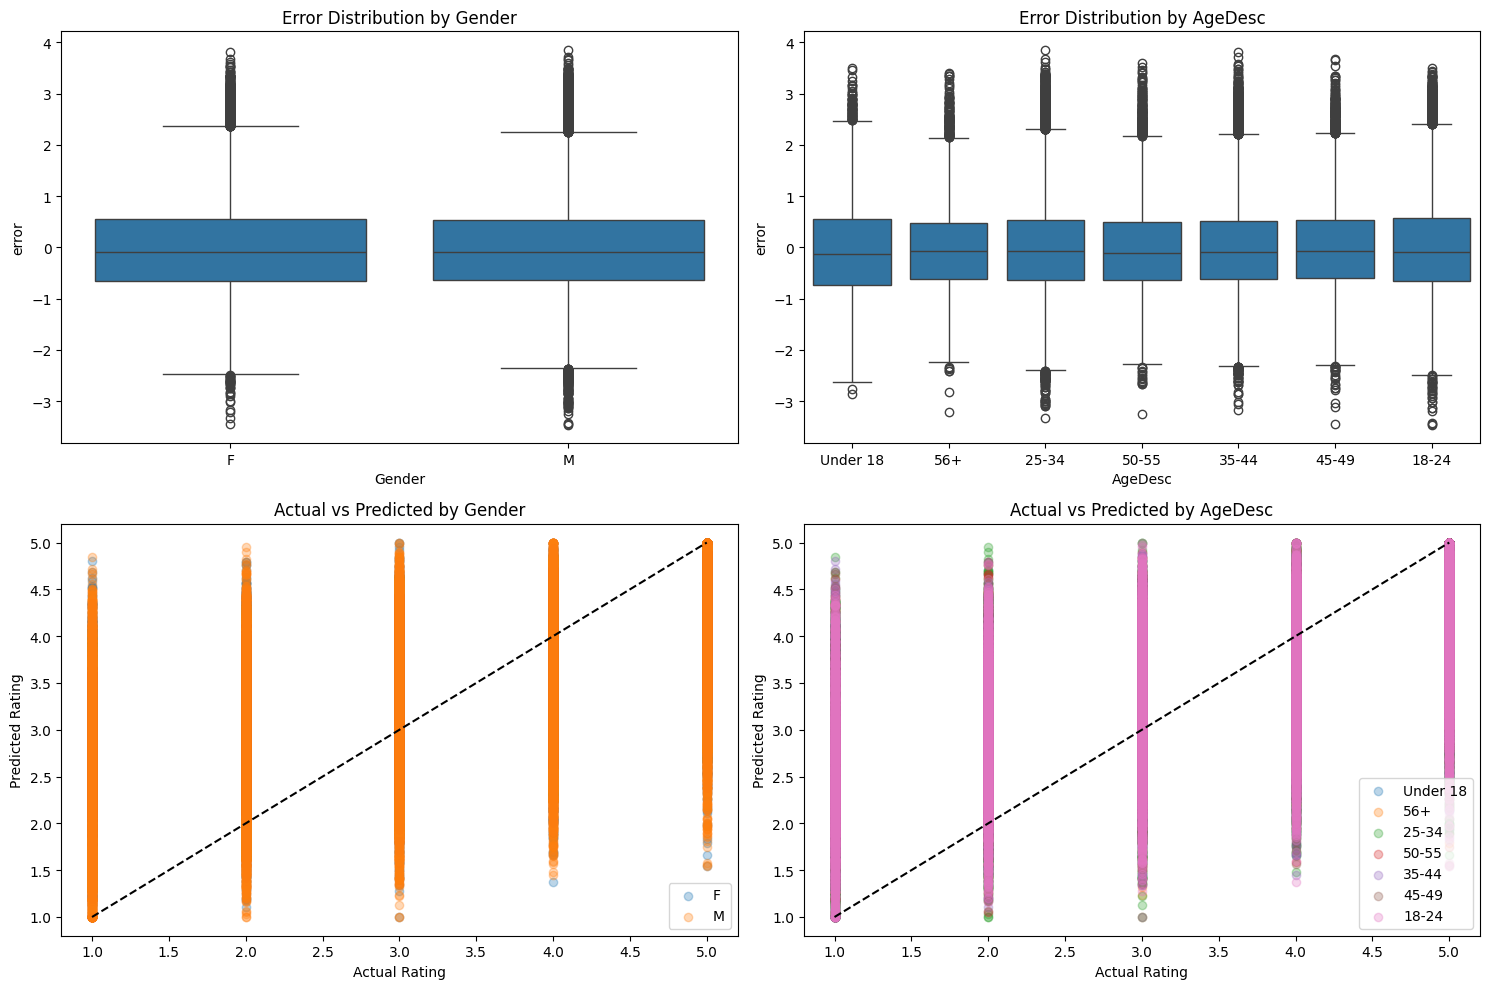

In [73]:
# Optional: Create visualizations
visualize_fairness_results(results_with_demographics, fairness_metrics)

## Fairness Metrics

In recommender systems, fairness is a critical consideration to ensure equitable treatment of users. Fairness can be evaluated at two levels:

- **Individual Fairness**: Focuses on ensuring that each user, regardless of their characteristics, receives recommendations of similar quality.
- **Group Fairness**: Ensures that different demographic groups (e.g., based on gender, age, etc.) experience comparable recommendation quality, preventing systematic bias against certain groups.


### Individual fairness

To quantify individual fairness, we implemented two complementary metrics:

1. **Gini Coefficient** - Measuring inequality in prediction error distribution across all users
2. **Bottom-N Average** - Assessing the experience of users receiving the worst recommendation quality


#### Gini coefficient

Understanding the Gini coefficient result helps us assess individual fairness in our recommendation system. This metric measures how equally recommendation quality (precision) is distributed across all users, regardless of their demographic groups.

=== Gini Coefficient Fairness Metric ===
Gini Coefficient: 0.1321 (0 = perfect equality, 1 = perfect inequality)
Calculated across 4558 users with top-10 recommendations
Relevance threshold: Rating >= 4.0


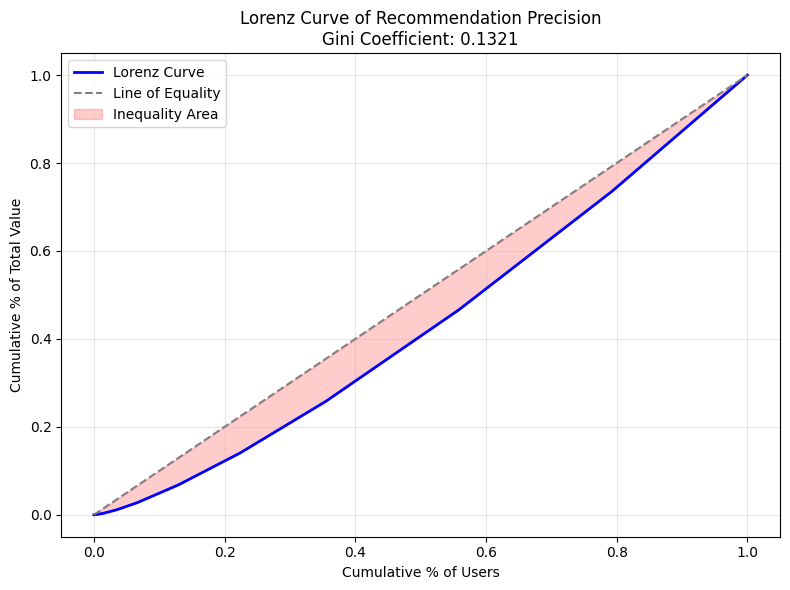

In [74]:
# Calculate Gini coefficient as a fairness metric
gini, user_precisions = evaluate_gini_fairness(
    final_model, 
    testset,
    threshold=4.0,  
    n=10,           
    plot=True       
)

A Gini coefficient of 0.1321 indicates a relatively low level of inequality in recommendation quality. For context, perfect equality (where every user receives exactly the same quality of recommendations) would yield a coefficient of 0, while extreme inequality (where only one user receives all the good recommendations) would approach 1.

The moderate value we observed suggests that our SVD++ model provides reasonably consistent recommendation quality across the user base. However, the non-zero value also indicates that some users do receive better recommendations than others. The Lorenz curve visualization reveals this disparity - the area between the blue curve and the diagonal line of equality represents the degree of inequality.

This metric matters for fairness because users expect consistent service quality regardless of who they are. A recommendation system with high inequality might be technically accurate on average but could be delivering dramatically different experiences to different users, potentially disadvantaging certain individuals in ways that aren't captured by group-level metrics.

#### Bottom N-average

The Bottom-N Average metric provides a critical perspective on individual fairness by focusing specifically on the experience of the worst-served users in our recommendation system. Unlike aggregate metrics that can mask disparities, this approach directly examines whether our system is leaving certain users behind.

=== Bottom-N Average Individual Fairness Metric ===
Total number of users: 4558
Bottom 5 users average: 1.6455
Bottom 10 users average: 1.8953
Bottom 20 users average: 2.0912
Bottom 50 users average: 2.3280
Bottom 1% of users (45 users) average: 2.3021
Bottom 5% of users (227 users) average: 2.6921
Bottom 10% of users (455 users) average: 2.8737
Bottom 20% of users (911 users) average: 3.0598
Overall average across all users: 3.6623
Disparity between overall and bottom 1%: 1.3602 (37.1%)
Disparity between overall and bottom 5%: 0.9702 (26.5%)
Disparity between overall and bottom 10%: 0.7886 (21.5%)
Disparity between overall and bottom 20%: 0.6026 (16.5%)


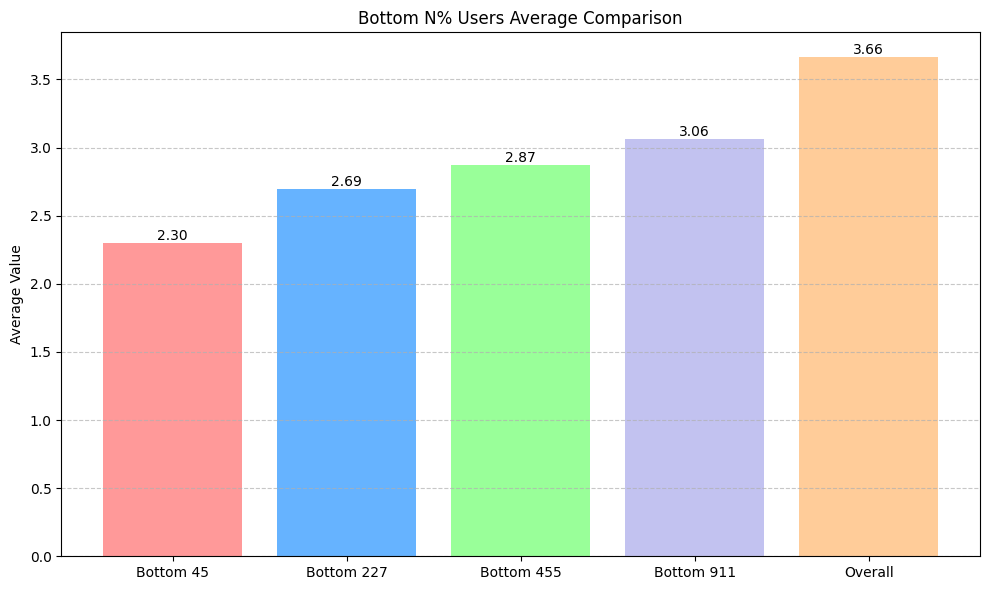

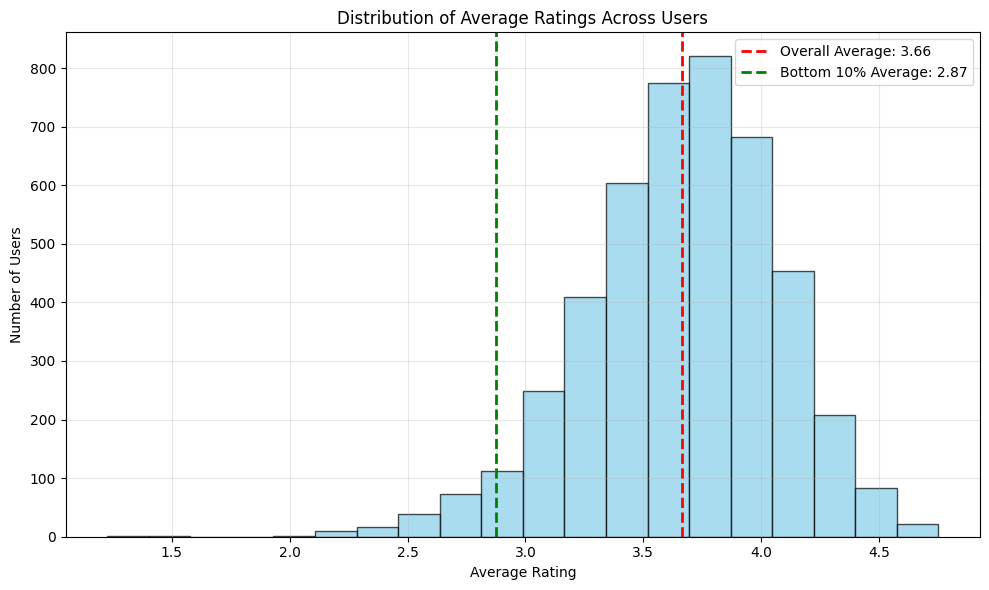

In [75]:
# Evaluate bottom-N as an individual fairness metric
bottom_n_results = evaluate_bottom_n_fairness(
    results_with_demographics,  
    ns=[5, 10, 20, 50],         
    user_column='UserID',       
    value_column='est'          
)

Our analysis reveals significant disparities between the average user experience and that of users receiving the poorest recommendations. While the overall average predicted rating across all 4,558 users is 3.66 (out of 5), the bottom 1% of users experience an average of just 2.30 - a 37.1% reduction in quality. This means that while most users receive predictions centered around 3.7 stars, the worst-served users receive predictions averaging only 2.3 stars, well below the "good" threshold typically associated with ratings of 3 and above. Even when looking at the bottom 20% of users, we still see a 16.5% disparity compared to the average, indicating that a substantial portion of our user base consistently receives lower-quality recommendations than others.

These gaps are particularly concerning from a fairness perspective because they indicate that a substantial minority of users receive significantly lower quality recommendations than the majority. Such disparities could lead to user frustration, reduced engagement, or platform abandonment among the affected individuals. The Bottom-N Average serves as an important fairness metric because it ensures we don't sacrifice the experience of individual users in pursuit of optimizing aggregate performance metrics.

### Group fairness

To assess fairness across demographic groups, we implemented two complementary metrics:

1. **N1-Norm** - Measuring absolute differences in prediction quality between demographic groups
2. **KL Divergence** - Quantifying the statistical distance between prediction distributions across different groups


#### N1-Norm

The N1-Norm fairness analysis provides a nuanced approach to detecting systemic biases in recommendation systems by examining the distribution of prediction errors across different demographic groups.

**Why Distribution Matters**

- Traditional fairness metrics often focus on point estimates like mean error. However, this approach can mask subtle systemic biases. The N1-Norm method goes deeper by:
    - Comparing the entire shape of error distributions, not just average values
    - Detecting nuanced variations that simple mean comparisons might miss
    - Quantifying how differently prediction errors are spread across groups

=== User-Focused N1-Norm Group Fairness Metric ===

Evaluating user fairness for Gender:

  RMSE distribution N1-norm:
    F: 0.4269 (high difference)
      Mean: 0.8981 vs Overall: 0.8724
      Difference: 0.0257 (2.9%)
    M: 0.1557 (moderate difference)
      Mean: 0.8631 vs Overall: 0.8724
      Difference: 0.0094 (1.1%)

  avg_pred distribution N1-norm:
    F: 0.2597 (high difference)
      Mean: 3.6996 vs Overall: 3.6623
      Difference: 0.0373 (1.0%)
    M: 0.0947 (low difference)
      Mean: 3.6488 vs Overall: 3.6623
      Difference: 0.0136 (0.4%)


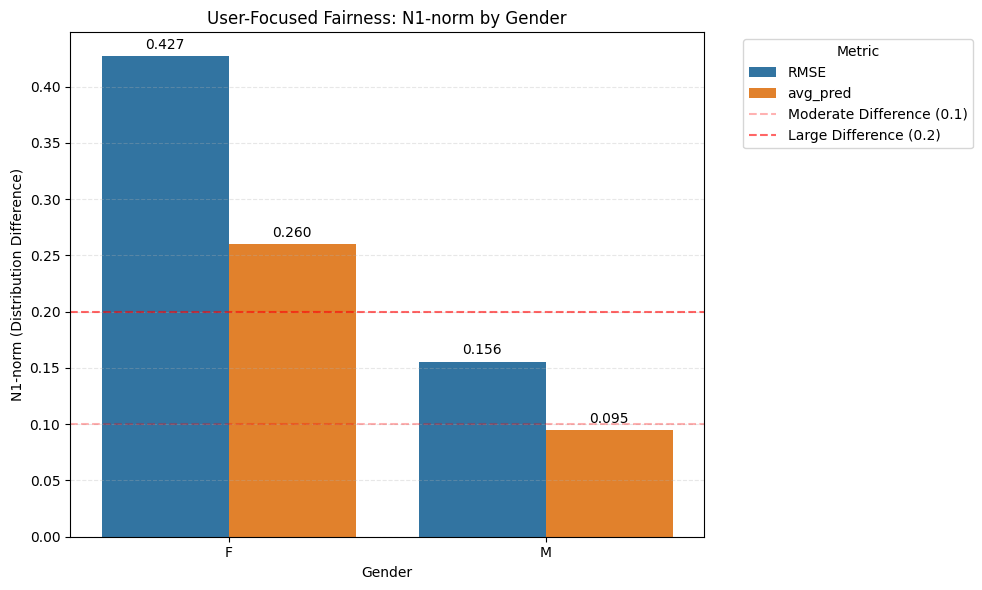

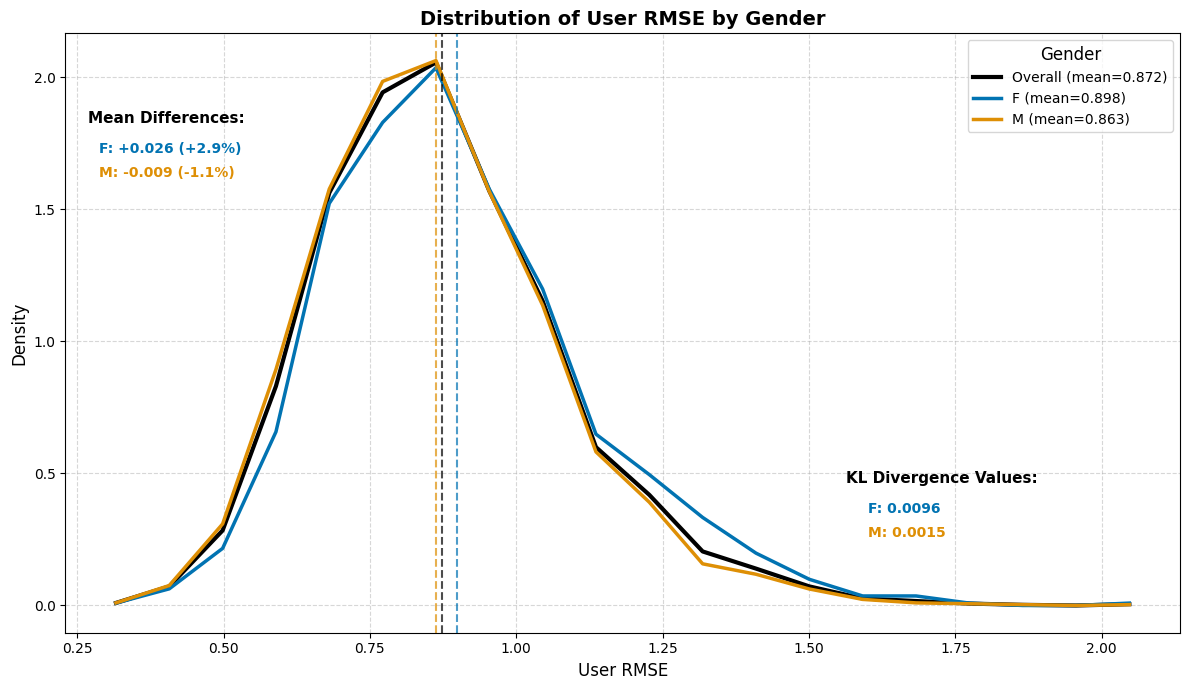

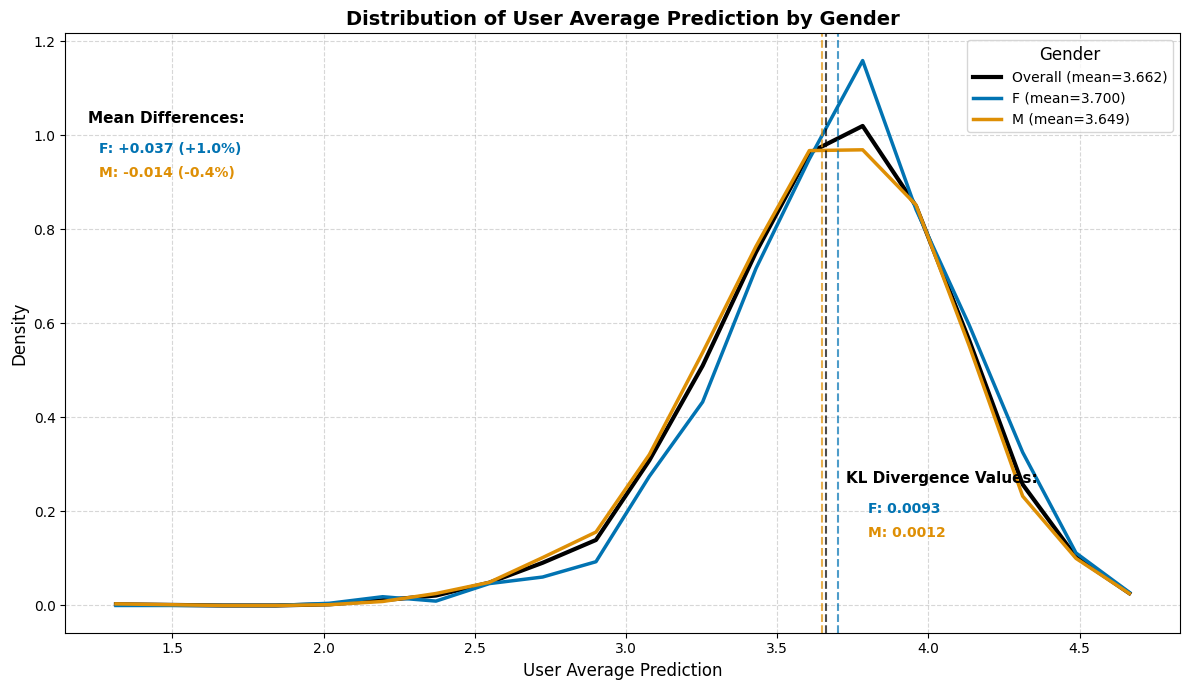


Summary Statistics for Gender:
  Group    Metric   Mean  Overall Mean  Difference  Difference %  N1-Norm
0     F      RMSE 0.8981        0.8724      0.0257        2.9410   0.4269
1     M      RMSE 0.8631        0.8724     -0.0094       -1.0725   0.1557
2     F  avg_pred 3.6996        3.6623      0.0373        1.0174   0.2597
3     M  avg_pred 3.6488        3.6623     -0.0136       -0.3710   0.0947


In [93]:
# Calculate user-level metrics
user_metrics_df = compute_user_metrics(
    results_with_demographics,
    user_col='UserID',
    rating_col='est',
    true_rating_col='r_ui'
)

# Run streamlined N1-norm fairness analysis
n1_results, user_metrics = evaluate_user_n1_norm_fairness(
    results_with_demographics,
    user_metrics_df=user_metrics_df,
    group_cols=['Gender'],  # Analyze one demographic at a time for clearer results
    metrics=['RMSE', 'avg_pred']  # Focus on key metrics
)

**Interpreting the Results**

In this analysis, the N1-Norm values reveal significant insights:

- RMSE N1-Norm for Females (0.4269): High distributional difference
    - Prediction errors are more variably distributed
    - Slightly higher mean error (0.8981 vs 0.8724)
    - Suggests potential systematic bias affecting female users' predictions

- RMSE N1-Norm for Males (0.1557): Moderate distributional difference
    - More consistent prediction error distribution
    - Slightly lower mean error (0.8631 vs 0.8724)

**Key Fairness Indicators**

- N1-Norm < 0.1: Low distributional difference
- 0.1 ≤ N1-Norm < 0.2: Moderate distributional difference
- N1-Norm ≥ 0.2: High distributional difference

The method reveals that while average differences seem small, the underlying error distributions vary significantly between groups, highlighting potential hidden biases in the recommendation system.

#### KL-divergence

The KL divergence analysis reveals subtle but important differences in how our recommendation system serves different demographic groups. While simple averages might suggest minor disparities, this deeper distributional analysis shows clear patterns in the user experience across gender groups.

=== User-Focused KL Divergence Group Fairness Metric ===

Evaluating KL divergence fairness for Gender:

  RMSE KL divergence results:
  Group  KL Divergence Interpretation  Mean Diff %  Sample Size
0     F         0.0096            low       2.9410         1218
1     M         0.0015            low       1.0725         3340

  avg_pred KL divergence results:
  Group  KL Divergence Interpretation  Mean Diff %  Sample Size
0     F         0.0093            low       1.0174         1218
1     M         0.0012            low       0.3710         3340


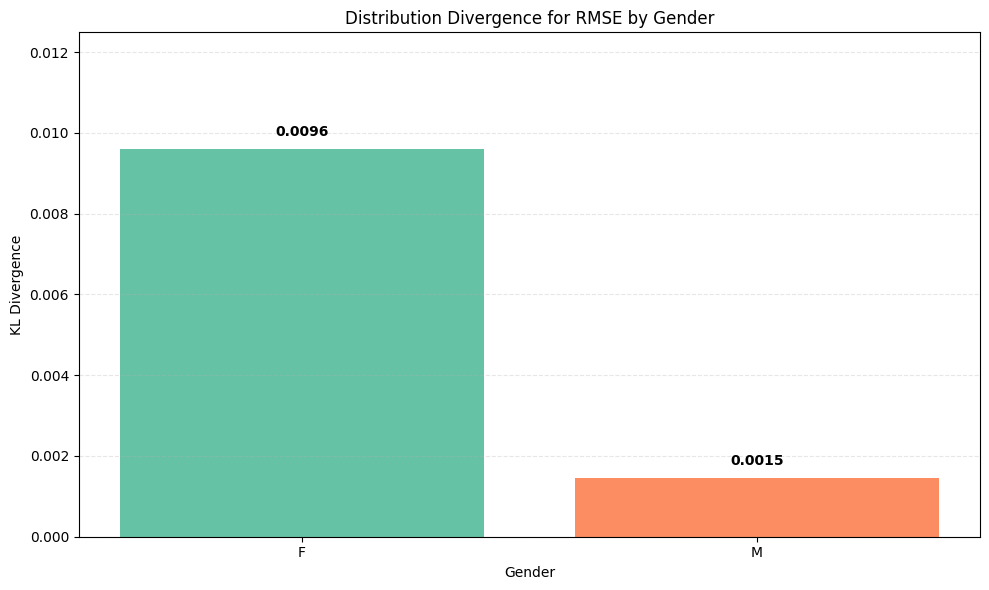

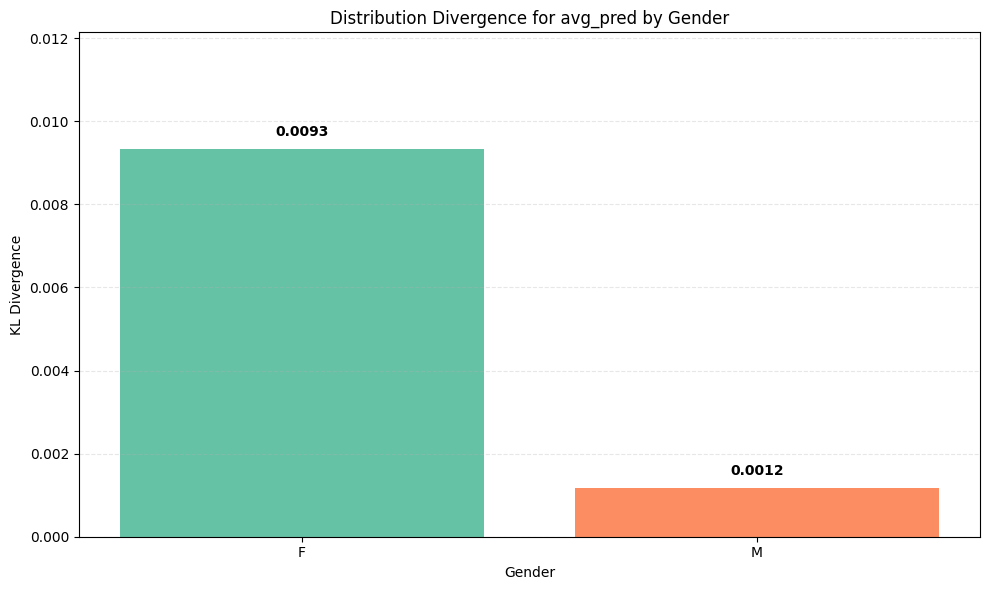

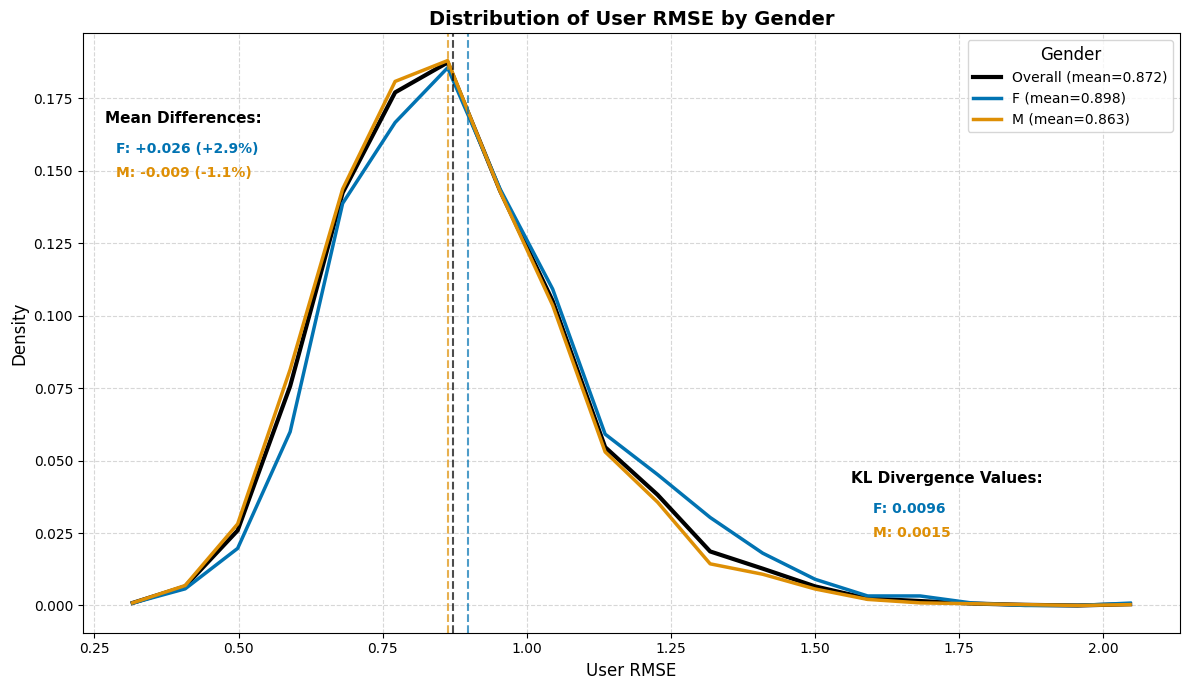

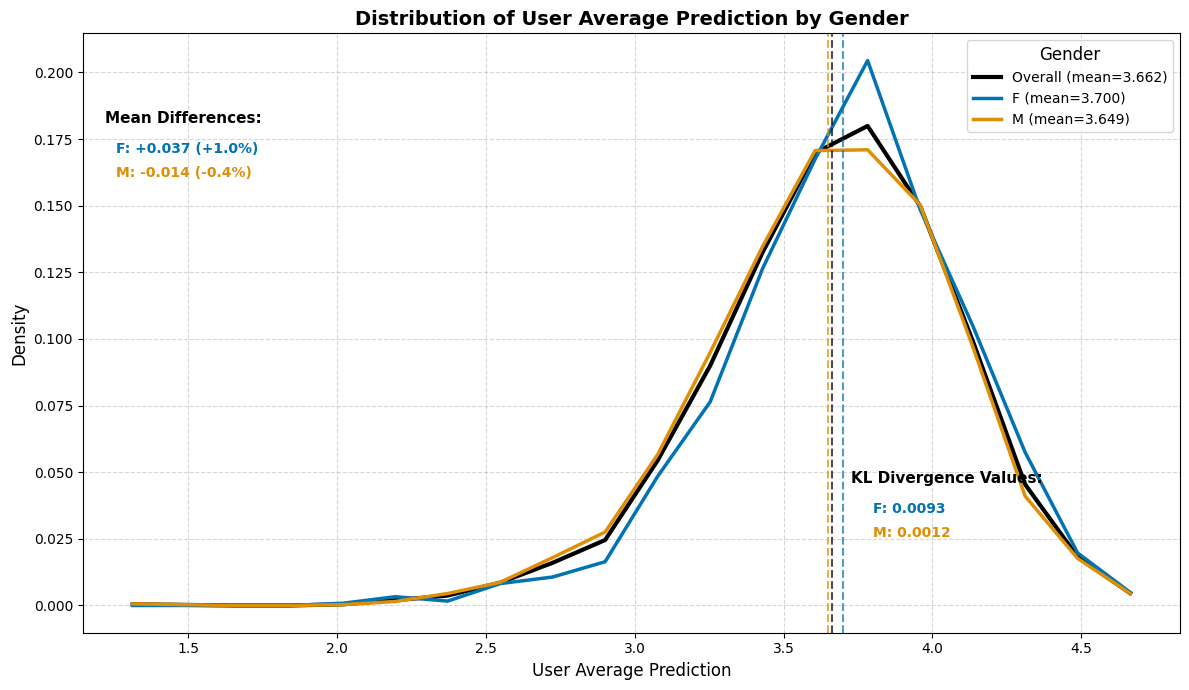

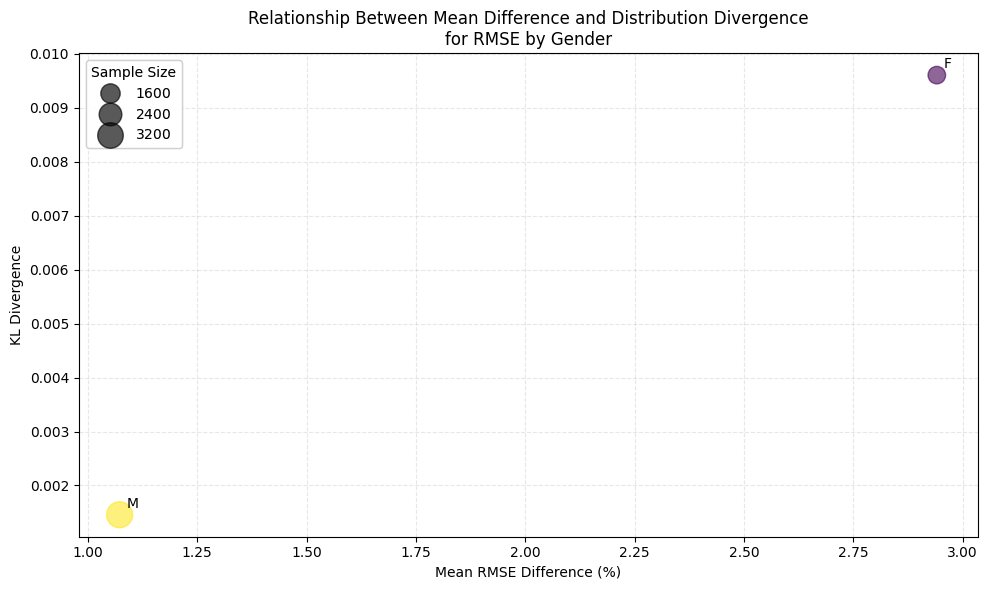

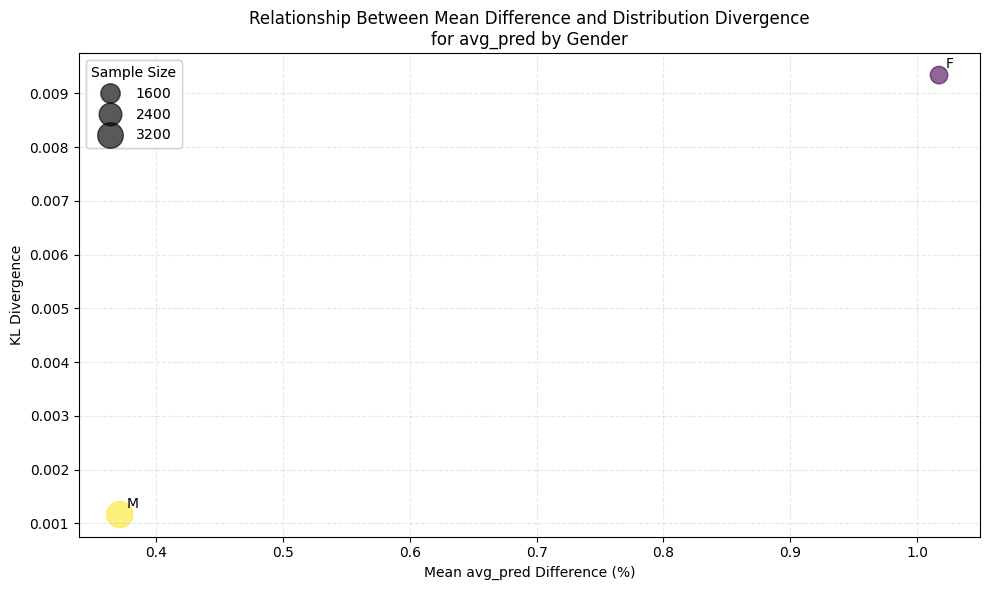

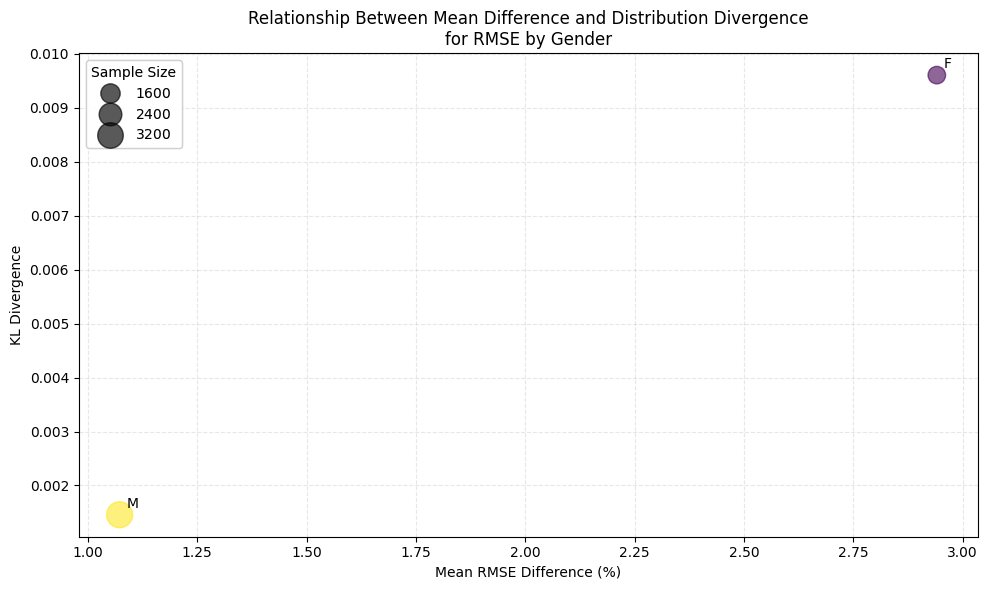

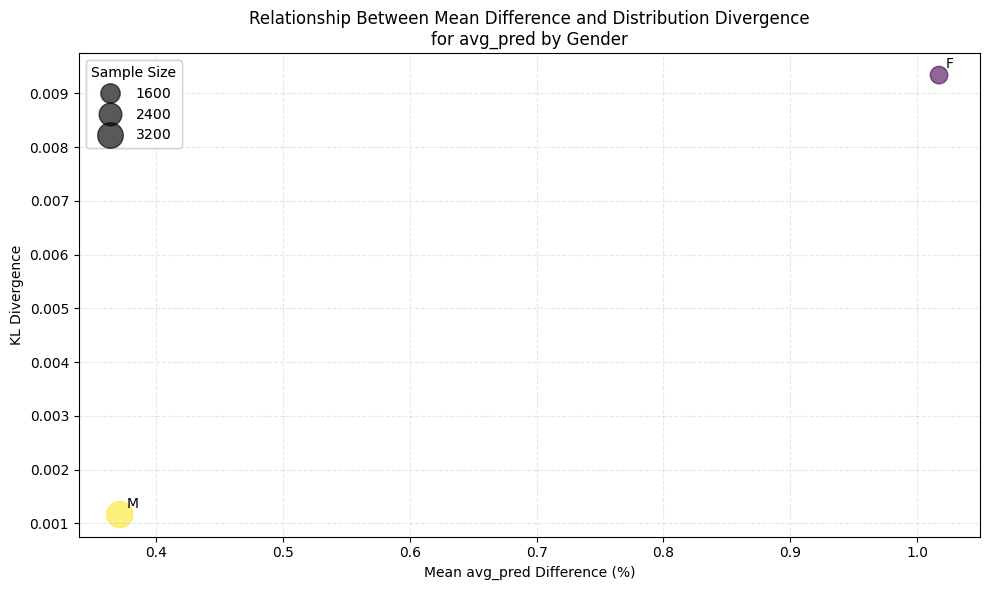

In [102]:
# Define your demographic columns and metrics
group_cols = ['Gender']  # You can add more like 'AgeDesc'
metrics = ['RMSE', 'avg_pred']

# Run the analysis
results, user_metrics = evaluate_user_kl_divergence_fairness(
    results_with_demographics,
    user_metrics_df=None,  # Will be calculated internally
    group_cols=group_cols,
    metrics=metrics
)

# If you want to create additional visualizations after running the analysis:
for group_col in group_cols:
    for metric in metrics:
        metric_data = results[group_col][metric]
        
        # Create additional visualization if needed
        plot_kl_vs_metric_diff(
            metric_data['kl_results'],
            metric_data['stats'],
            group_col,
            metric
        )
        plt.show()

For RMSE (prediction accuracy), female users experience a distribution that diverges more substantially from the overall population (KL divergence of 0.0096) compared to male users (0.0015). This sixfold difference in divergence suggests that female users' experience is less represented in the overall system behavior, despite the mean difference appearing modest at 2.94%.


Similarly for average predictions, female users again show higher divergence (0.0093 vs 0.0012), indicating systematic differences in how ratings are distributed. The visualization of these distributions shows that female users experience both higher error rates and slightly higher average predictions.

KL divergence serves as a powerful fairness metric because it captures the full shape of the experience distribution rather than just averages. Even when mean differences appear small, significant distributional differences can indicate that a system consistently treats certain groups differently - providing either more variable, less accurate, or systematically biased recommendations. This analysis helps identify these subtler forms of unfairness that might otherwise go undetected with simpler metrics.

# UserKNN